# QUBO and Rydberg energies

This notebook aims at providing the functions for plotting the energy and probability differences between QUBO and Rydberg atoms.

In addition, it discusses how to obtain the J1, J2 and J3 parameters for both Rydberg atoms and QUBO.

<b>NB: You already have all the functions in the utils. The only difference is that in get_final_ryd_Hamiltonian_v2 I divided the final energy by the ration (that didn't seem to be done in the utils functions)</b>

<b>Replace the path to the atoms indices in the cell below if you don't have the same folder structure.</b>

In [71]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

from utils import *

from braket.ahs.atom_arrangement import AtomArrangement
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation


In [56]:
atom_indices = np.loadtxt('./data/atom_indices_8_no_pbc.csv',delimiter=",", dtype=float)
atom_indices = atom_indices.astype('int')

## <a id='mapping'>Direct mapping</a>

When mapping the formation energy directly to the system of Rydberg atoms we use:

\begin{equation}
    \text{minimise} \sum_{k}^{N_{\text{train}}} \left( \Delta E_{k}^{f(n)}(\mu) - \left(J1 \sum_{i}^{N_{\text{sites}}} x_{i} + J2 \sum_{i,j}^{N_{\text{sites}}} \left(\frac{r_{NN}}{r_{i,j}}\right)^{6} x_{i} x_{j} \right)\right)^{2} 
\end{equation}

where $\Delta E_{k}^{f(n)}(\mu)$ is the formation energy of the structure $k$ in the grand canonical potential calculated using density functional theory (DFT). The terms $r_{NN}$ and $r_{i,j}$ are the distance between nearest neighbours and the distance between the sites $i$ and $j$, respectively. The term $x_i$ defines the occupancy of site $i$, $x_i=0$ means that site $i$ is occupied by a carbon atom and $x_i=1$ means that site $i$ is occupied by a nitrogen atom.

Using the J1 and J2 calculated with the equation above, we can build the QUBO model by using: $J1=J1$, $J2=J2-\frac{1}{27}J2$, $J3=\frac{1}{27}J2$

For comparison, when mapping the formation energy to the QUBO model, we use:

\begin{equation}
    \text{minimise} \sum_{k}^{N_{\text{train}}} \left( \Delta E_{k}^{f(n)}(\mu) - \sum_{i}\sum_{j>i} Q_{i,j} A_{i,j}^{k,n} \right)^{2}  
\end{equation}

where A$^{k,n}$ is the adjacency matrix of  structure $k$ up to the $n$-th nearest neighbour and including the $i=j$ terms. 

In [31]:
coords = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [0, -3],
          [0, -4],
         ]

neighbors = [
    (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (6, 7)
]

In [32]:
def tensor(N, indices):
    import functools as ft
    """Return the tensor product of a set of binary variables
    
    Example 1: 
        tensor(2, [0, 1]) = array([0, 0, 0, 1]) represents x0x1 with N=2 variables
    
    Example 2: 
        tensor(3, [0, 1]) = array([0, 0, 0, 0, 0, 0, 1, 1]) represents x0x1 with N=3 variables    
        
    Example 3: 
        tensor(3, [0, 2]) = array([0, 0, 0, 0, 0, 1, 0, 1]) represents x0x2 with N=3 variables    
        
    Example 4: 
        tensor(3, [1]) = array([0, 0, 1, 1, 0, 0, 1, 1]) represents x1 with N=3 variables    
        
    Example 5: 
        tensor(3, [0,1,2]) = array([0, 0, 0, 0, 0, 0, 0, 1]) represents x0x1x2 with N=3 variables    
        
    """
    
    list_binary_variables = [(1, 1) for _ in range(N)]
    for ind in indices:
        list_binary_variables[ind] = (0, 1)
        
    return ft.reduce(np.kron, list_binary_variables)

In [33]:
def get_next_nearest_neighbors(neighbors):
    """Return the next nearest neighbors from a given set of neighbors
    
    Example:
        >>> neighbors = [
            (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (6, 7)
        ]
        
        >>> get_next_nearest_neighbors(neighbors)
        >>> [(2, 3), (4, 5), (0, 3, 6), (0, 2, 6), (1, 5, 7), (1, 4, 7), (2, 3), (4, 5)]
    """
    
    
    num_atoms = max(list(sum(neighbors, ()))) + 1
    first_neighbors = [[] for _ in range(num_atoms)]

    for pair in neighbors:
        first_neighbors[pair[0]].append(pair[1])
        first_neighbors[pair[1]].append(pair[0])


    next_nearest_neighbors = [[] for _ in range(num_atoms)]
    for i in range(num_atoms):
        temp = []
        for j in first_neighbors[i]:
            temp += first_neighbors[j]
            
        next_nearest_neighbors[i] = tuple(set(temp) - {i})    
        
    return next_nearest_neighbors

In [34]:
def QUBO(neighbors, J1=0.080403, J2=0.019894, J3=0.0):
    """Return the spectrum and solutions for a QUBO problem defined as
    
        H = J1 \sum_i x_i + J2 \sum_{<i,j>}x_ix_j + J3 \sum_{<<i,j>>}x_ix_j
    
    where J1 is the coefficient for the linear term, and J2 and J3 are the coefficients
    for the nearest neighbor and next nearest neighbor interactions.
    
    """
    
    
    J1 = float(J1)
    J2 = float(J2)
    num_atoms = max(list(sum(neighbors, ()))) + 1
    
    H = 0
    # Add the linear tearm or the potential term
    for i in range(num_atoms):
        H += J1 * tensor(num_atoms, [i])    
        
    # Add the nearest neighbor interaction
    for (i,j) in neighbors:
        if i < j:
            H += J2 * tensor(num_atoms, [i, j])
    
    
    # Add the next nearest neighbor interaction
    next_nearest_neighbors = get_next_nearest_neighbors(neighbors)
    for i in range(num_atoms):
        for j in next_nearest_neighbors[i]:
            if i < j:
                H += J3 * tensor(num_atoms, [i, j])    
    
    
    # Get the minimum, and its configuration
    min_val = min(H)
    min_val_indices = [i for i in range(len(H)) if H[i]==min_val]
    configs = [f'{index:0{num_atoms}b}' for index in min_val_indices]
    
    return H, min_val, min_val_indices, configs  

In [35]:
def get_final_ryd_Hamiltonian_v2(
    coords, 
    detuning = 125000000.0,
    J1=0.080403, 
    J2=0.019894,
    C6 = 5.42e-24
):
    """
        Return the Rydberg Hamiltonian for a given atom arrangement and a QUBO model, version 2
        
        
        Args:
            coords: The coordinates of atoms and we assume that the nearest neighbor distance is 1. 
            detuning: The detuning in the Rydberg Hamiltonian
            J1: The linear term in the QUBO
            J2: The nearest neighbor interaction in the QUBO
            C6: The Rydberg interaction constant
            
        Notes:
            In this version, we have only one formula for R, namely (C6/detuning * -J1/J2)**(1/6).
            We return ratio = abs(detuning / J1) to map the spectrums
            
    """
    
    num_atoms = len(coords)
    
    if J1 == 0:
        detuning = 0
#         R = 8e-6
    elif J1 < 0:
        detuning = abs(detuning)
    else:
        detuning = -abs(detuning)
    
    
    
    R = (C6/detuning * -J1/J2)**(1/6)
    ratio = abs(detuning/1e6 / J1)
    
    
    # We will define the Hamiltonian via a ficticious AHS program
    
    # Define the register 
    register = AtomArrangement()

    for coord in coords:
        register.add(np.array(coord) * R)
        
    # Define a const driving field with zero Rabi frequency, and 
    # max allowed detuning
    t_max = 4e-6
    Omega = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)
    Delta = TimeSeries().put(0.0, detuning).put(t_max, detuning)
    phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)
    
    drive = DrivingField(
        amplitude=Omega,
        phase=phi,
        detuning=Delta
    )
    
    program = AnalogHamiltonianSimulation(
        hamiltonian=drive,
        register=register
    )
    
    
    # Now extract the Hamiltonian as a matrix from the program
    
    program = convert_unit(program.to_ir())
        
    configurations = get_blockade_configurations(program.setup.ahs_register, 0.0)

    
    rydberg_interaction_coef = RYDBERG_INTERACTION_COEF / ((SPACE_UNIT**6) / TIME_UNIT)
        
    rabi_ops, detuning_ops, interaction_op, local_detuning_ops = _get_sparse_ops(
        program, configurations, rydberg_interaction_coef
    )
        
    t_max_converted = program.hamiltonian.drivingFields[0].amplitude.time_series.times[-1]
    rabi_coefs, detuning_coefs, local_detuing_coefs = _get_coefs(program, [0, t_max_converted])
    
#     print(f"interaction_op={interaction_op}")
#     print(f"detuning_ops[0]={detuning_ops[0]}")
#     print(f"detuning_coefs[0][-1]={detuning_coefs[0][-1]}")
    
    H = interaction_op - detuning_ops[0] * detuning_coefs[0][-1]
    
    # H is diagonal
    diagH = np.real(H.diagonal())/ratio
    
    min_val = min(diagH)
    min_val_indices = [i for i in range(len(diagH)) if diagH[i]==min_val]
    configs = [f'{index:0{num_atoms}b}' for index in min_val_indices]
    
    
    return diagH, min_val, min_val_indices, configs, R, ratio

In [59]:
E_ryd = get_final_ryd_Hamiltonian_v2(
    coords, 
    detuning = 125000000.0,
    J1=0.08843826,J2=0.01255761,
    C6 = 5.42e-24
)[0]
#E_ryd

In [60]:
# From H_ryd mapping: J1=0.08843826, J2=0.01209251, J3=0.0004651
E_QUBO = QUBO(neighbors, J1=0.08843826, J2=0.01209251, J3=0.0004651)[0]
#E_QUBO-E_ryd

In [61]:
configurations = np.array(list(itertools.product([0, 1], repeat=8)))
config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
E_QUBO_sic = np.array(E_QUBO_sic)
E_ryd_sic = np.array(E_ryd_sic)

In [99]:
def plot_E_p_differences(configurations,multiplicty,E_QUBO,E_ryd,percent=True,title=None):
    
    import matplotlib.pyplot as plt
    
    Z_ryd, pi_ryd = get_partition_function(E_ryd, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    Z_QUBO, pi_QUBO = get_partition_function(E_QUBO, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    

    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    #fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    n_ones = np.sum(configurations,axis=1)

    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
        axs[0].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
        axs[1].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
    if percent == True:
        delta_E = ((E_QUBO[1:]-E_ryd[1:])/E_QUBO[1:])*100
        delta_E = np.append(np.array([0]),delta_E)
    else:
        delta_E = E_QUBO-E_ryd
    axs[0].bar(np.arange(len(E_QUBO)),delta_E,width=0.5,label='J')

    axs[0].set_xlabel('SIC index',fontsize=14)
    
    axs[0].legend()

    axs[1].bar(np.arange(len(E_QUBO)),pi_ryd-pi_QUBO)
    axs[1].set_xlabel('SIC index',fontsize=14)
    axs[1].set_ylabel('Probability difference',fontsize=14)
    
    if percent == True:
        axs[0].set_ylabel('Energy difference (%)',fontsize=14)

    else:
        axs[0].set_ylabel('Energy difference',fontsize=14)
    
    if title is not None:
        fig.suptitle(title,y=0.96, fontsize=20)
        
    plt.show()
    
#plot_E_p_differences(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,percent=False,title=None)

In [100]:
def plot_E_p_differences_v2(configurations,multiplicty,E_QUBO,E_ryd,percent=True, title=None):
    
    np.errstate(divide='ignore')
    Z_ryd, pi_ryd = get_partition_function(E_ryd, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    Z_QUBO, pi_QUBO = get_partition_function(E_QUBO, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.)
    

    fig, axs = plt.subplots(2,3,figsize=(18, 10), sharey=False)
    #fig.suptitle('J1={}, J2={}, J3={}, mu={}'.format(J1,J2,J3,J1*mu,),fontsize=16)
    
    n_ones = np.sum(configurations,axis=1)

    areas = np.where(np.sort(n_ones)[:-1]-np.sort(n_ones)[1:] == -1)[0]
    areas = np.append(-1,areas)
    areas = np.append(areas,len(config_unique))
    
    
    #plt.bar(np.arange(len(E_structure)),E_structure,width=0.5)
    
    if percent == True:
        delta_E = ((E_QUBO[1:]-E_ryd[1:])/E_QUBO[1:])*100
        delta_E = np.append(np.array([0]),delta_E)
    else:
        delta_E = E_QUBO-E_ryd
    axs[0][0].bar(np.arange(len(E_QUBO)),E_QUBO,width=0.5,label='J')
    axs[0][1].bar(np.arange(len(E_QUBO)),E_ryd,width=0.5,label='J')
    axs[0][2].bar(np.arange(len(E_QUBO)),delta_E,width=0.5,label='J')

#     axs[0].set_xlabel('SIC index',fontsize=14)
#     axs[0].set_ylabel('Energy',fontsize=14)
#     axs[0].legend()
    axs[1][0].bar(np.arange(len(E_QUBO)),pi_QUBO,width=0.5,label='J')
    axs[1][1].bar(np.arange(len(E_QUBO)),pi_ryd,width=0.5,label='J')
    axs[1][2].bar(np.arange(len(E_QUBO)),pi_ryd-pi_QUBO,width=0.5,label='J')
    
    colors = ['#CECECE50','#DEDEDE']

    hatchs = ['//','\\\\']
    
    for j in range(2):
        for k in range(3):
            axs[j][k].set_xlabel('SIC index',fontsize=14)
            for i in range(len(areas)-1):
        #print(areas[i]+1, areas[i+1])
                axs[j][k].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
                axs[j][k].axvspan(areas[i]+1, areas[i+1], color=colors[0], hatch=hatchs[i%2], alpha=0.3,)
    axs[0][0].set_ylabel('QUBO energy (eV)',fontsize=14)
    axs[0][1].set_ylabel('Rydberg energy (eV)',fontsize=14)
    if percent == True:
        axs[0][2].set_ylabel('Energy difference (%)',fontsize=14)
    else:
        axs[0][2].set_ylabel('Energy difference (eV)',fontsize=14)
    axs[1][0].set_ylabel('QUBO probability',fontsize=14)
    axs[1][1].set_ylabel('Rydberg probability',fontsize=14)
    axs[1][2].set_ylabel('Probability difference',fontsize=14)
    
#     axs[1].set_xlabel('SIC index',fontsize=14)
#     axs[1].set_ylabel('Probability',fontsize=14)
    if title is not None:
        fig.suptitle(title,y=0.92, fontsize=20)
    plt.show()
    
#plot_E_p_differences_v2(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,percent=True, title=None)

## Compare Rydberg energies and QUBO energies calculated using the values obtained from the direct mapping

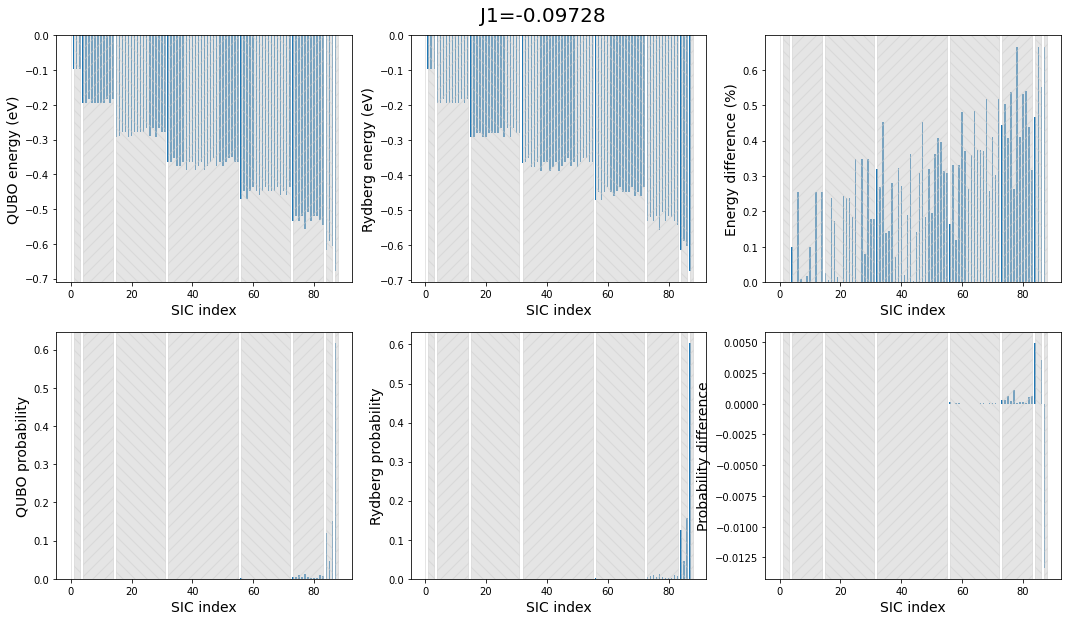

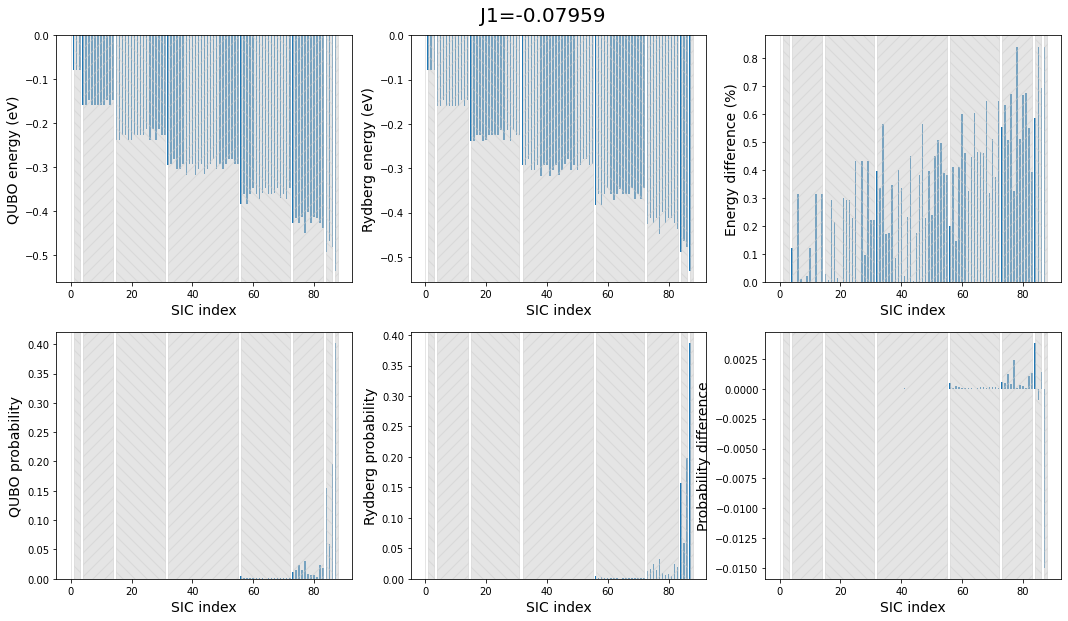

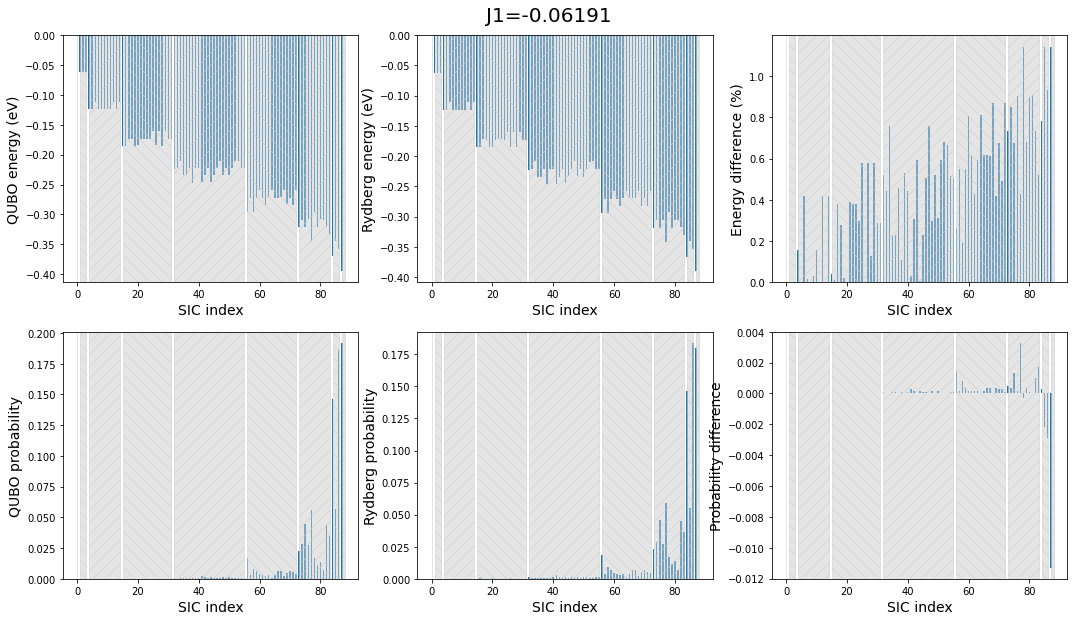

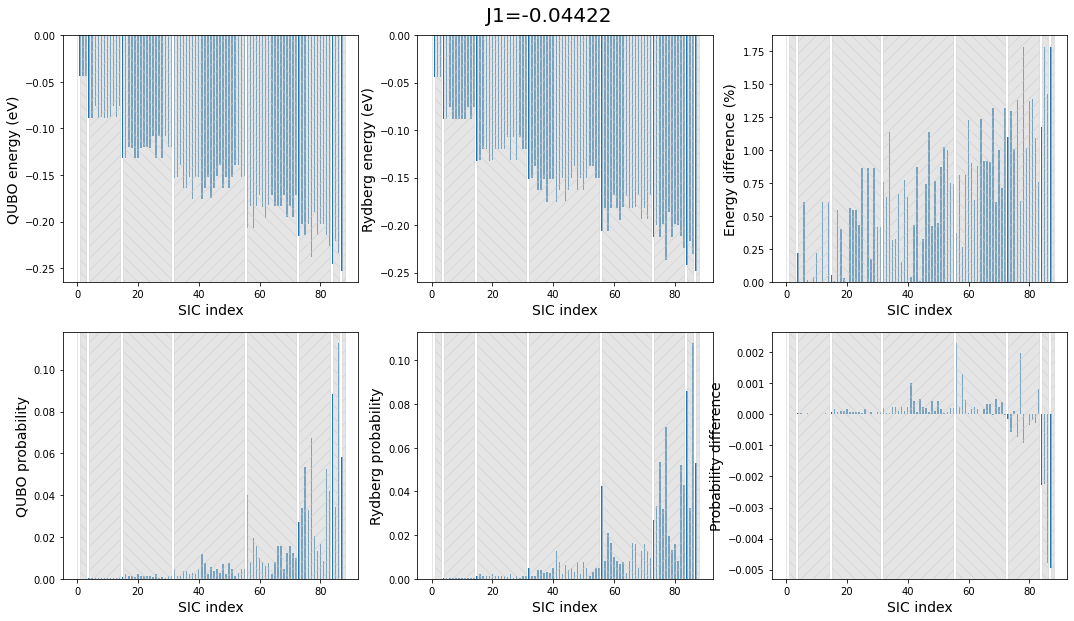

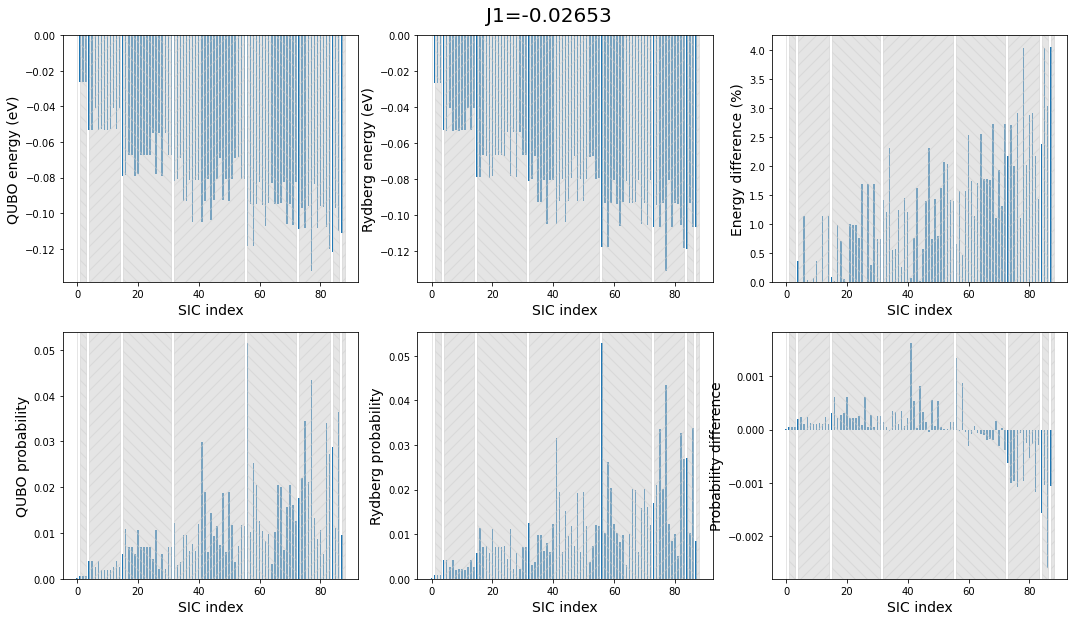

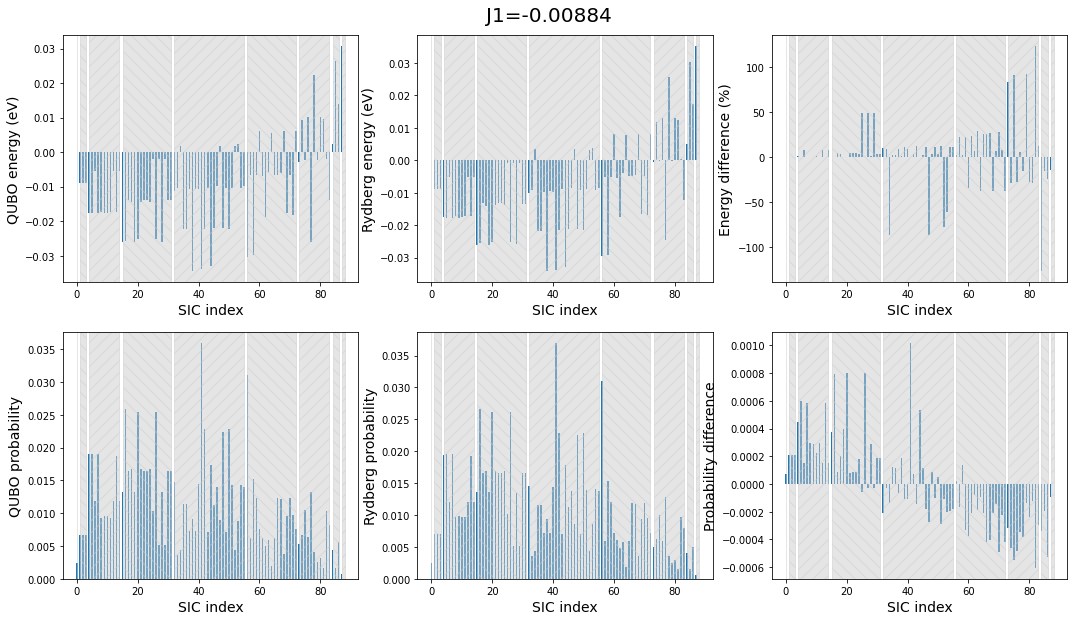

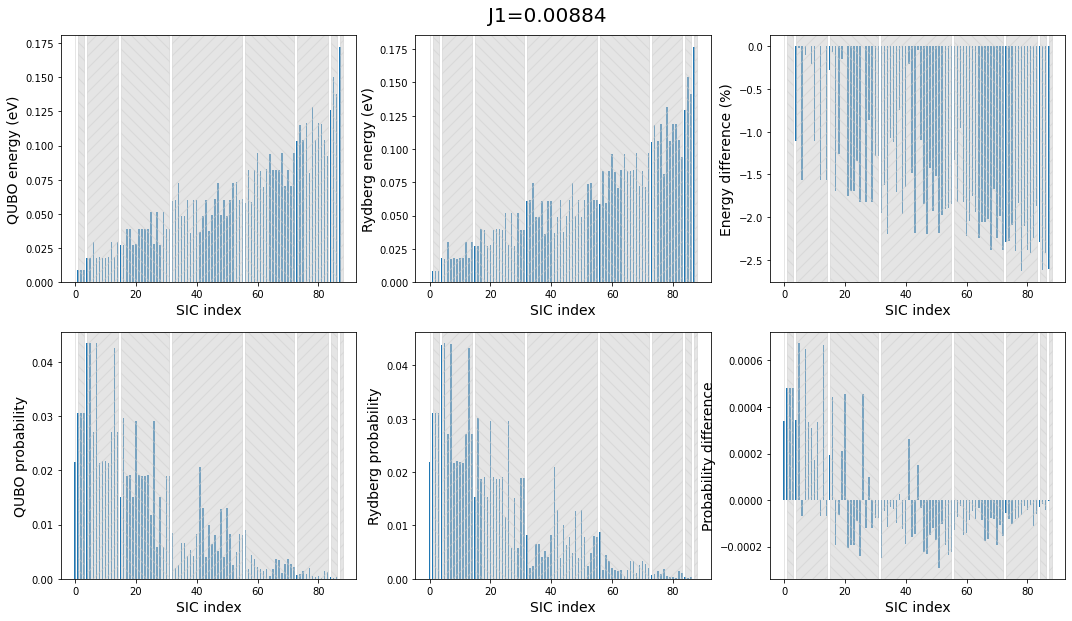

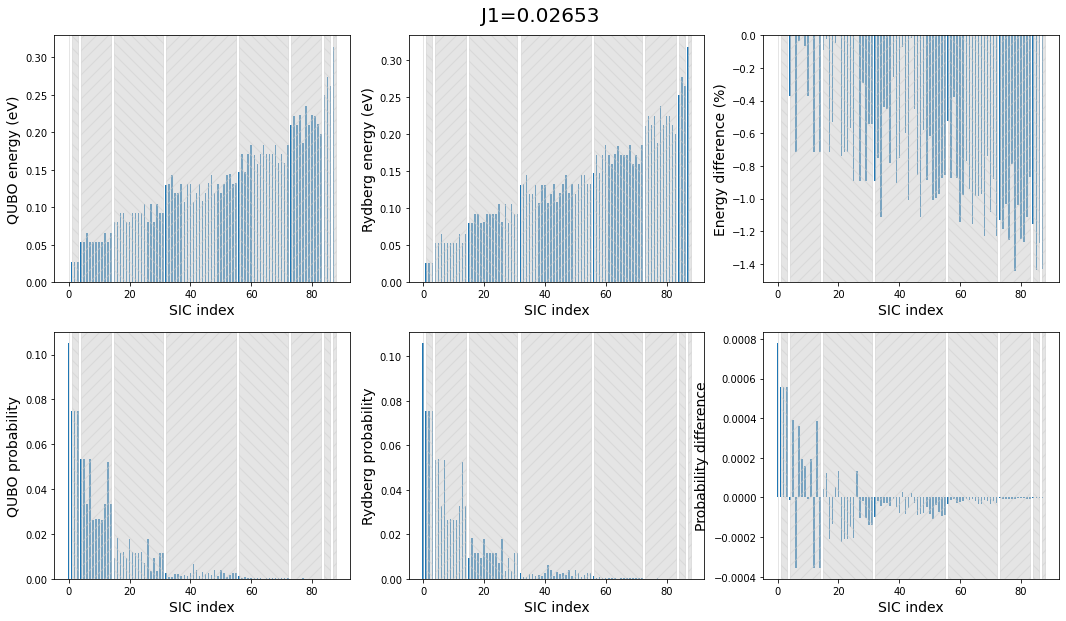

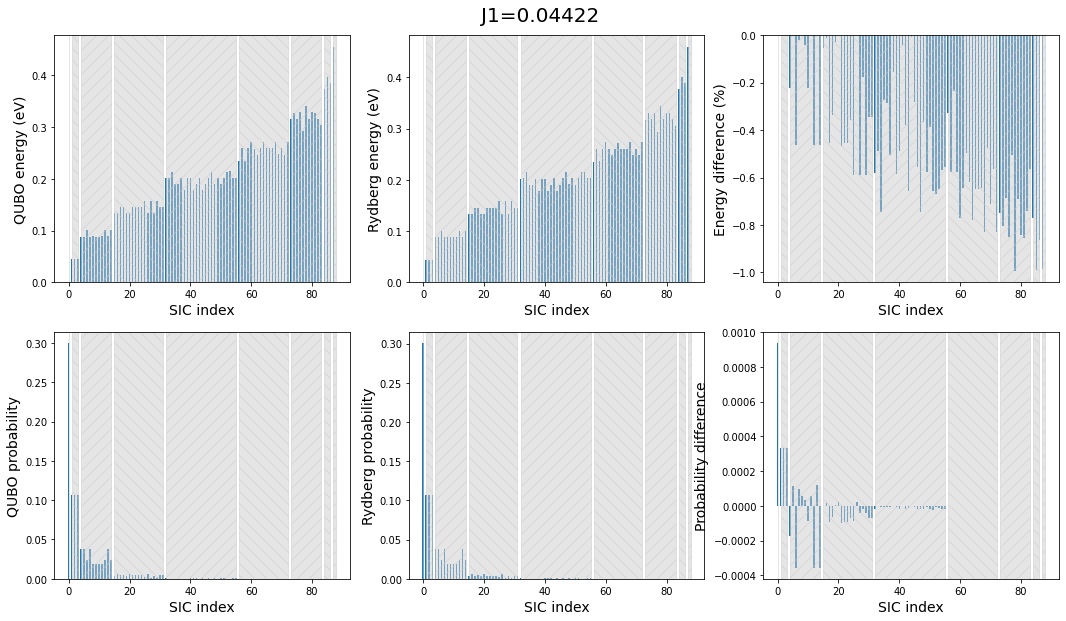

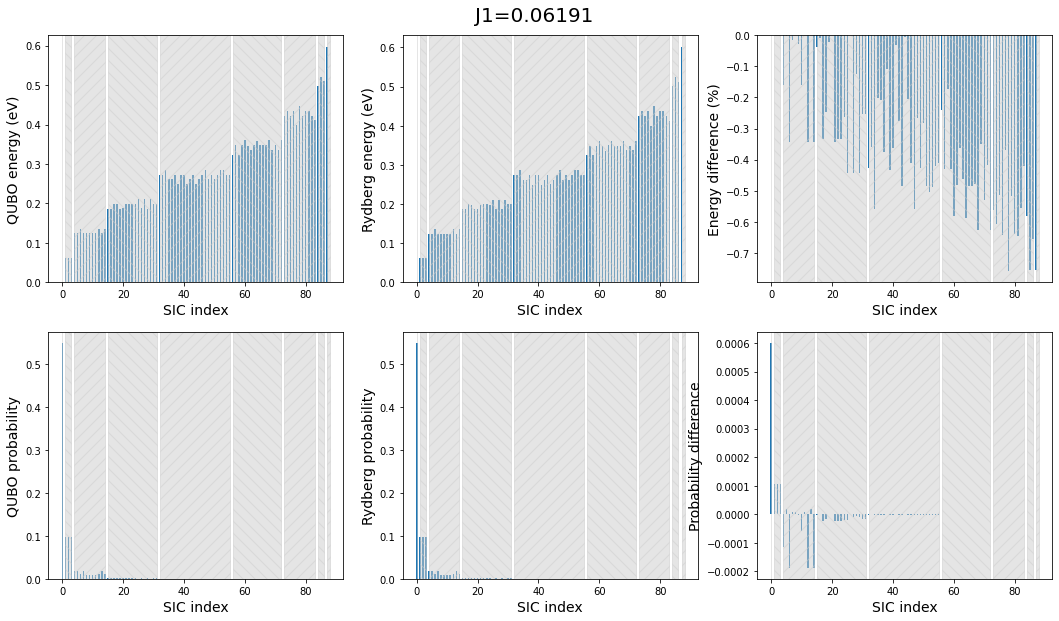

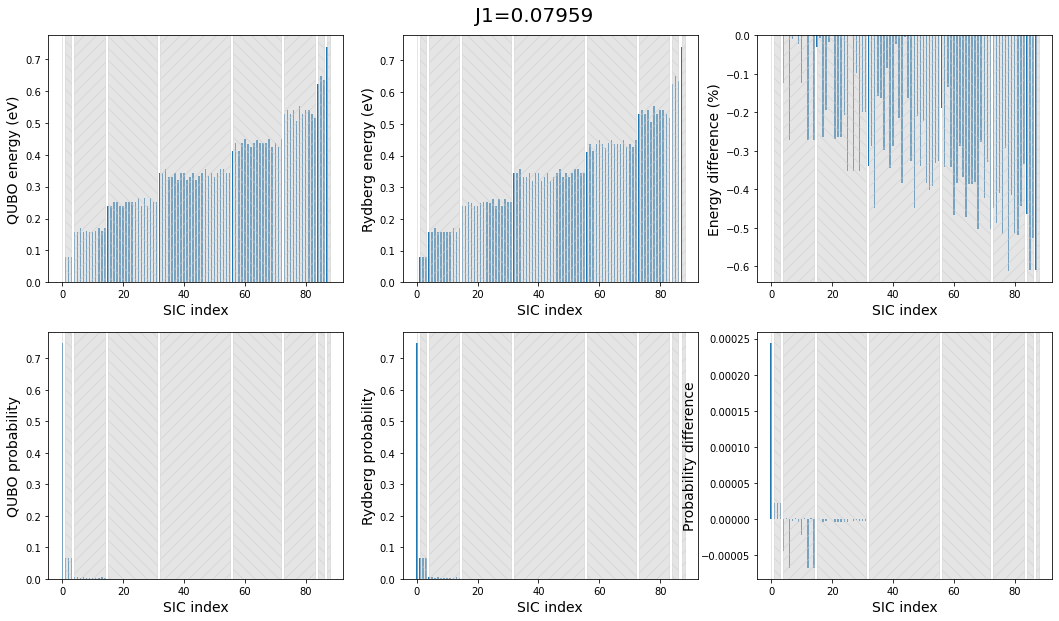

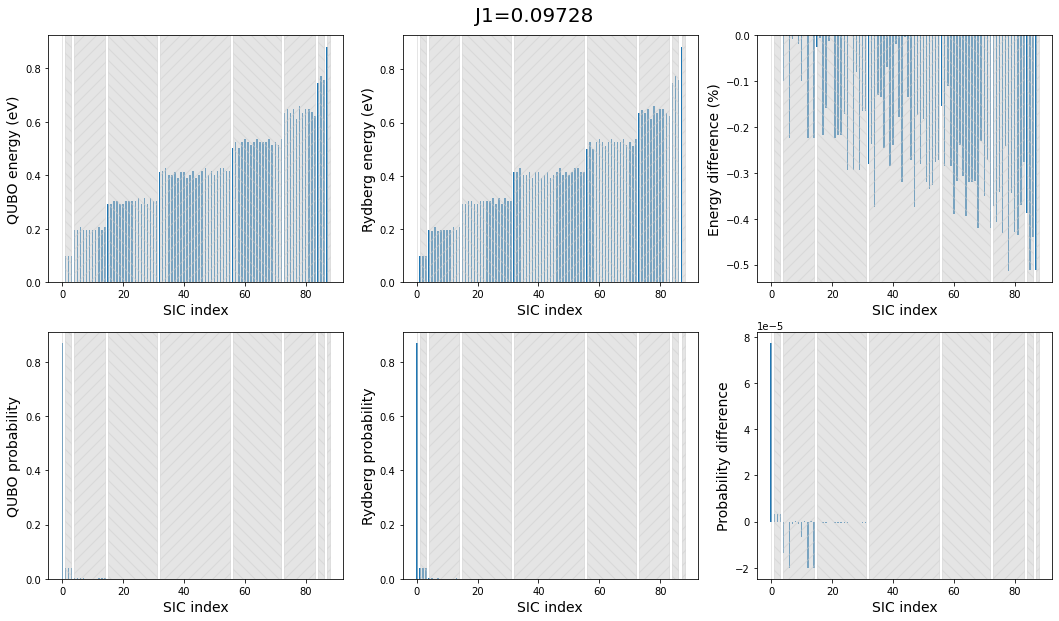

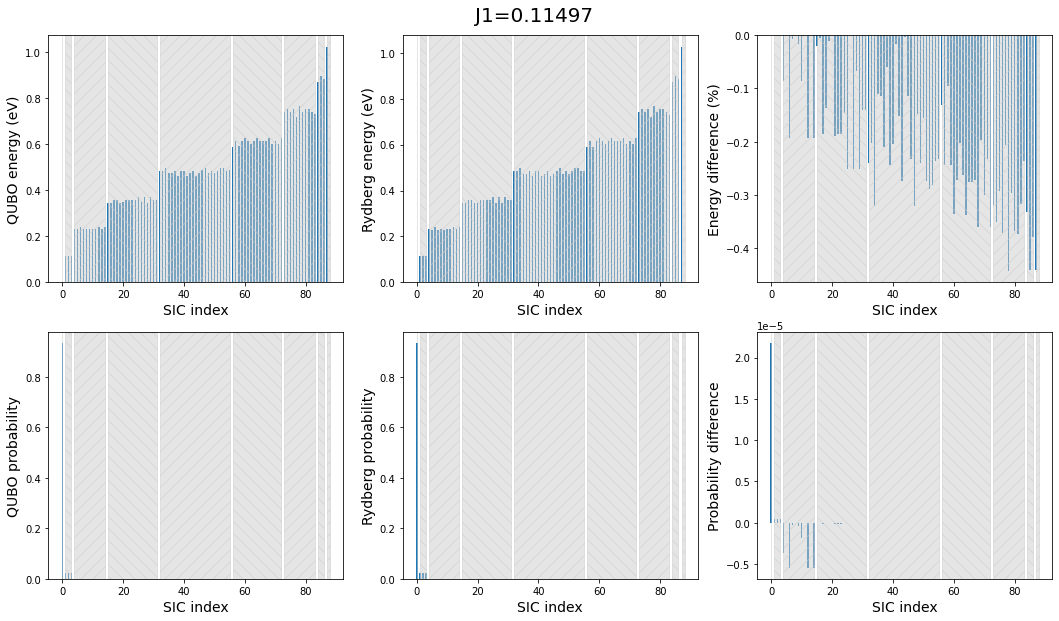

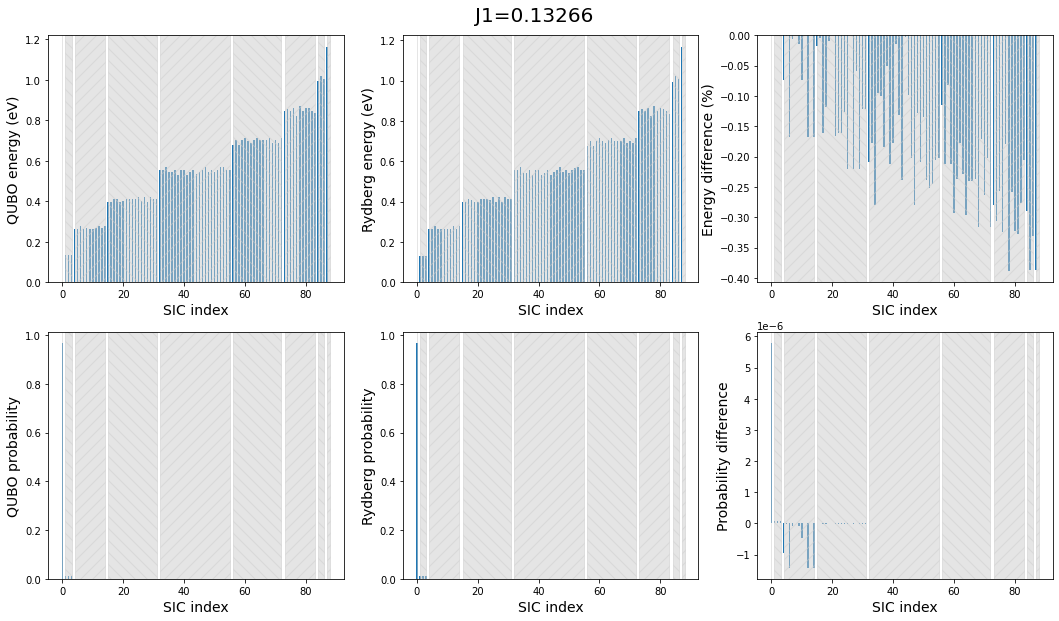

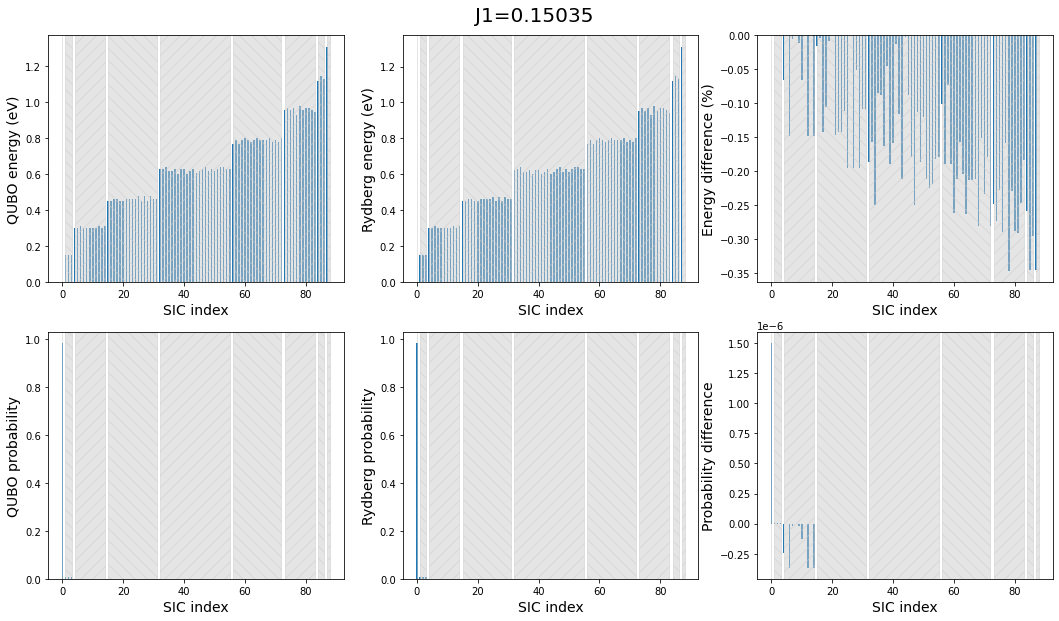

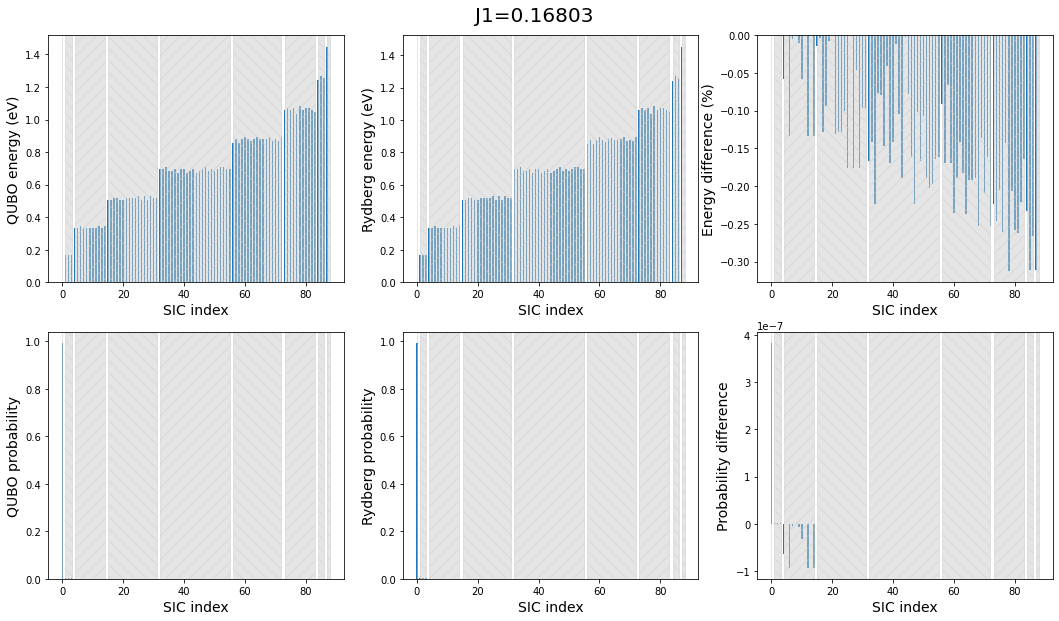

In [72]:
# QUBO values constrained

for mu in np.arange(-2.1,1,0.2):
    J1 = 0.08843826 + 0.08843826*mu
    E_ryd = get_final_ryd_Hamiltonian_v2(
        coords, 
        detuning = 125000000.0,
        J1=J1,J2=0.01255761,
        C6 = 5.42e-24)[0]
    E_QUBO = QUBO(neighbors, J1=J1, J2=0.01209251, J3=0.0004651)[0]
    
    configurations = np.array(list(itertools.product([0, 1], repeat=8)))
    config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
    config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
    E_QUBO_sic = np.array(E_QUBO_sic)
    E_ryd_sic = np.array(E_ryd_sic)
    plot_E_p_differences_v2(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,
                            percent=True, title='J1={}'.format(np.round(J1,5)))

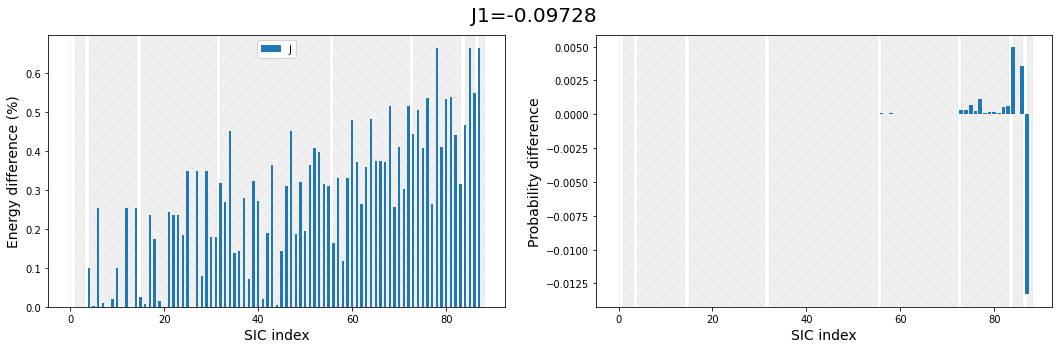

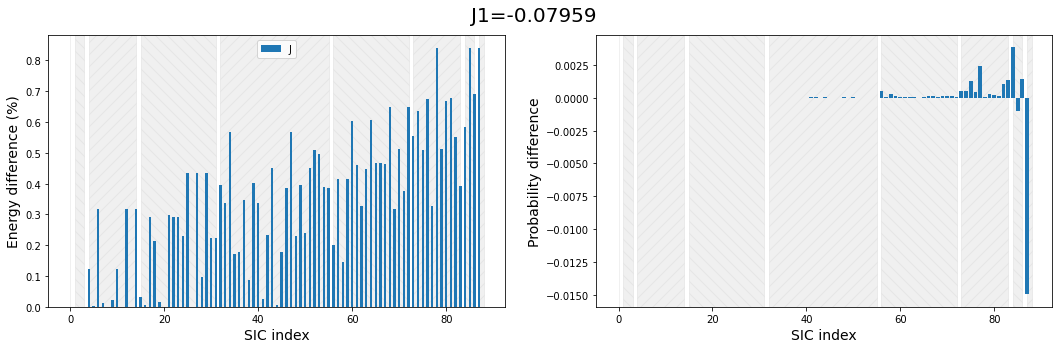

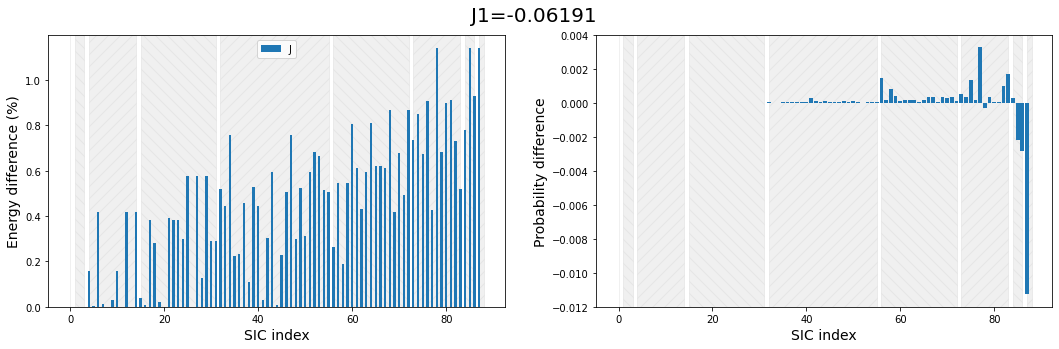

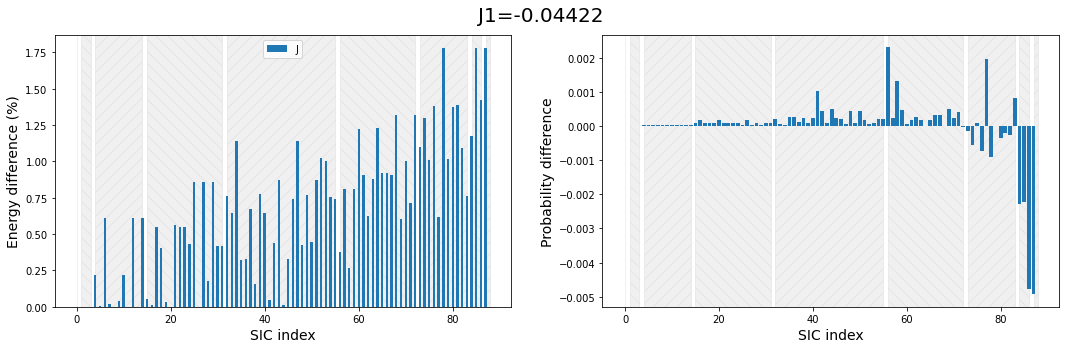

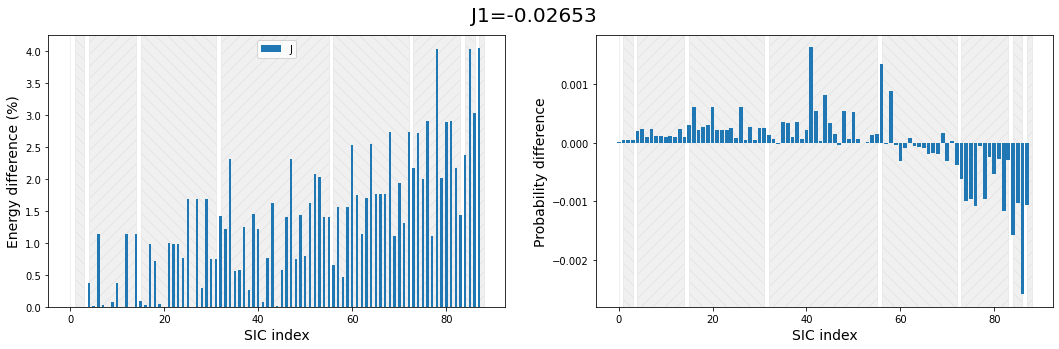

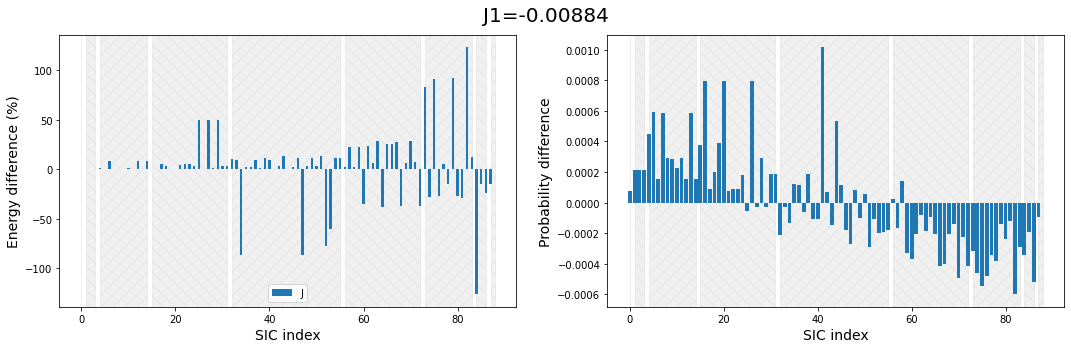

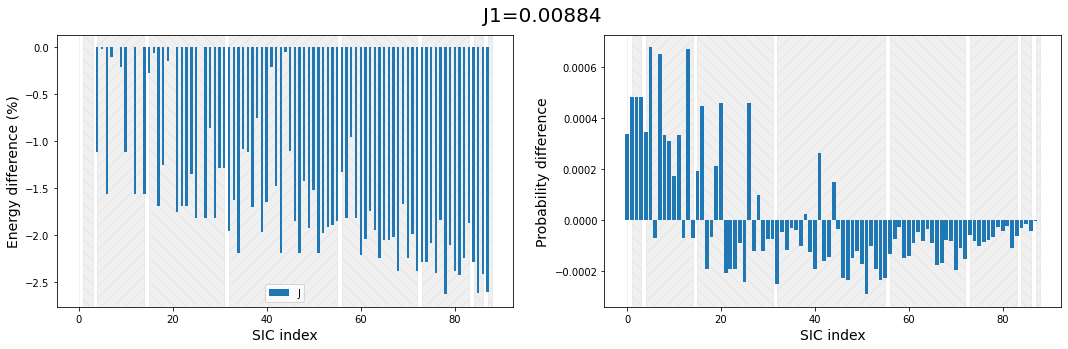

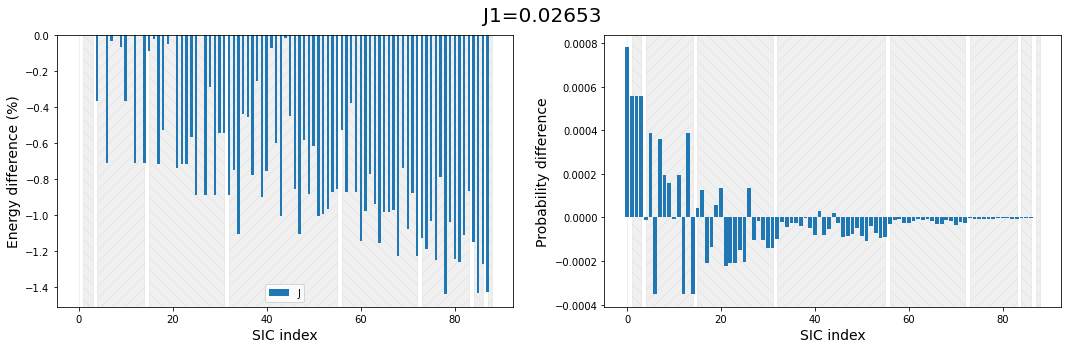

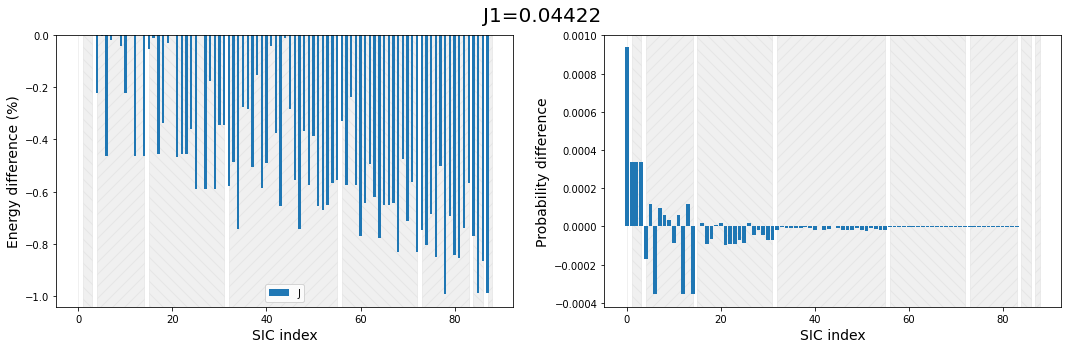

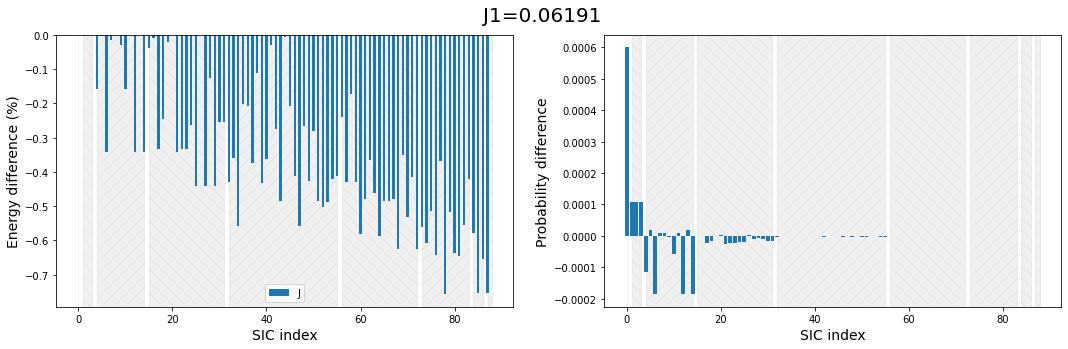

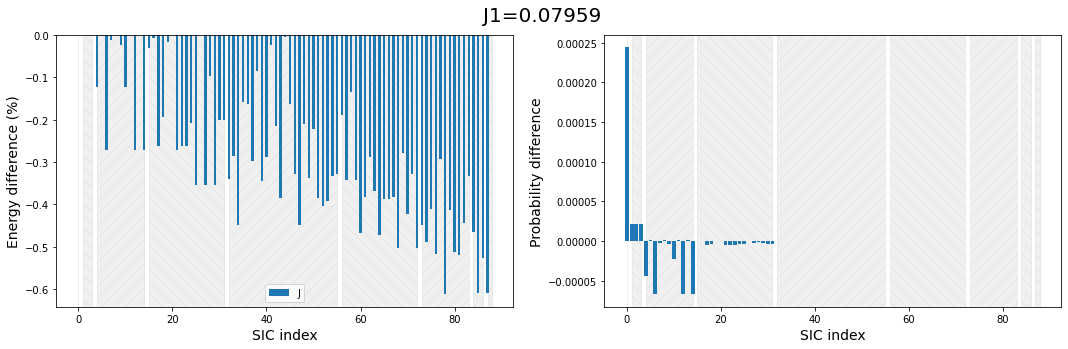

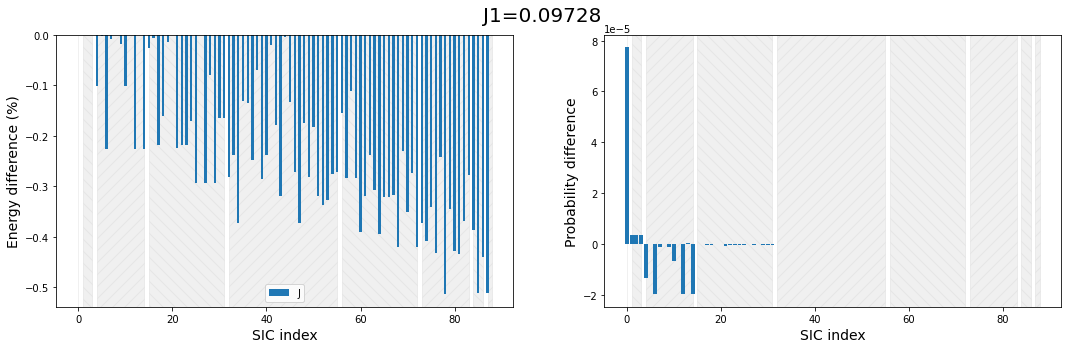

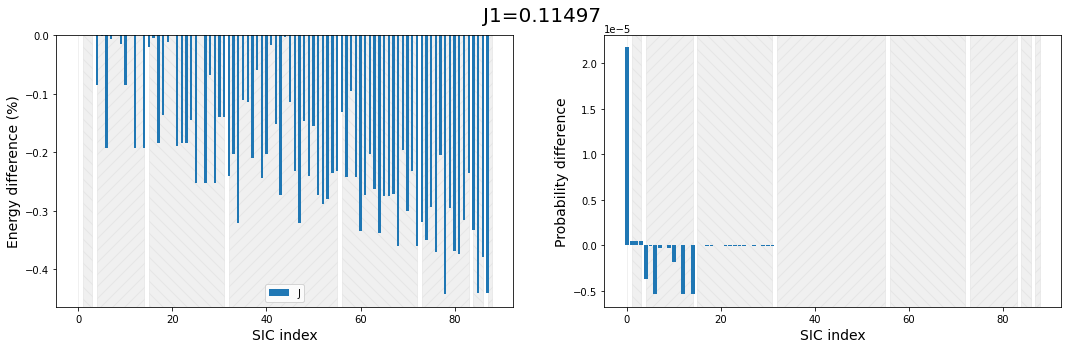

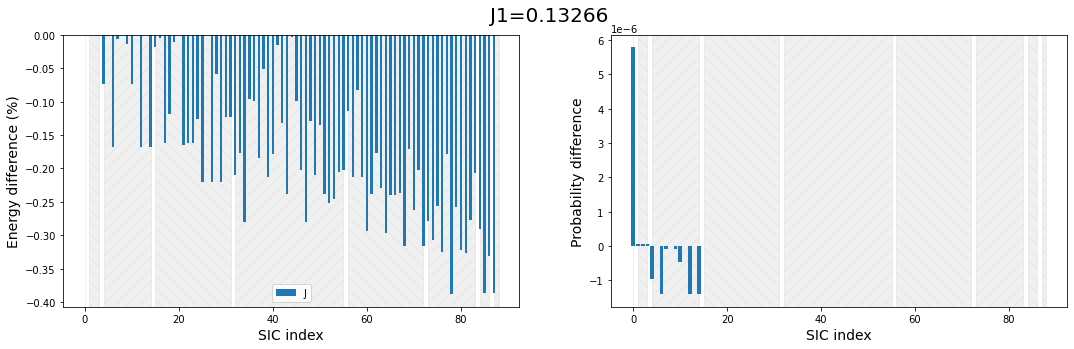

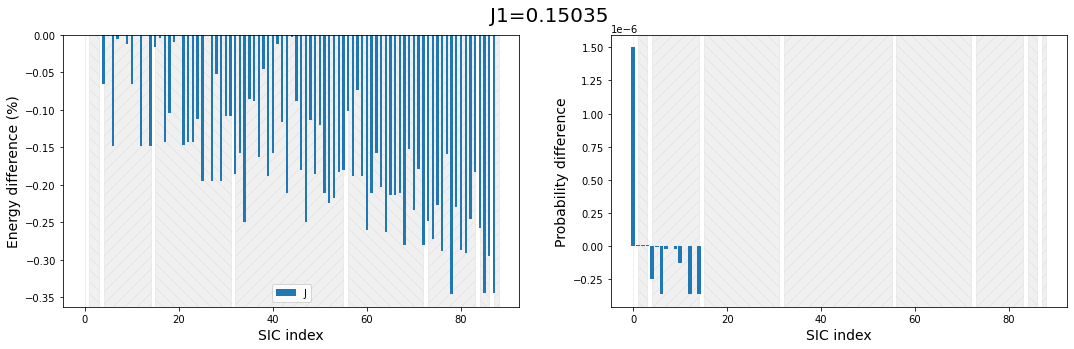

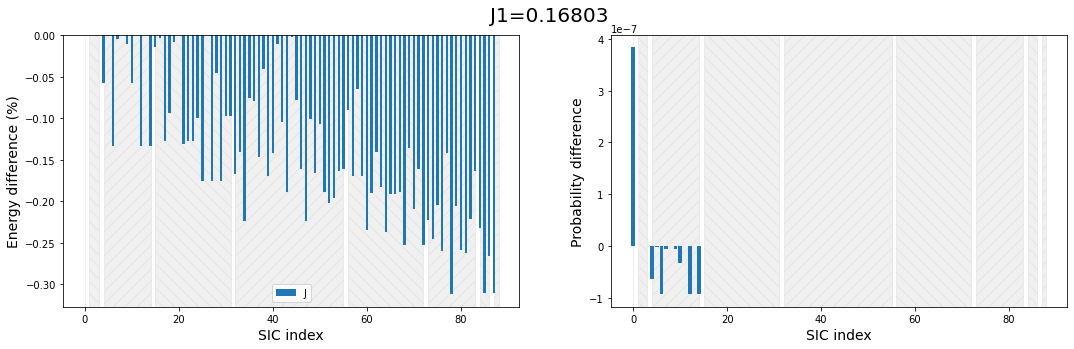

In [93]:
# QUBO values constrained

for mu in np.arange(-2.1,1,0.2):
    J1 = 0.08843826 + 0.08843826*mu
    E_ryd = get_final_ryd_Hamiltonian_v2(
        coords, 
        detuning = 125000000.0,
        J1=J1,J2=0.01255761,
        C6 = 5.42e-24)[0]
    E_QUBO = QUBO(neighbors, J1=J1, J2=0.01209251, J3=0.0004651)[0]
    
    configurations = np.array(list(itertools.product([0, 1], repeat=8)))
    config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
    config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
    E_QUBO_sic = np.array(E_QUBO_sic)
    E_ryd_sic = np.array(E_ryd_sic)
    plot_E_p_differences(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,
                            percent=True, title='J1={}'.format(np.round(J1,5)))

## Compare Rydberg energies and the real QUBO energies 

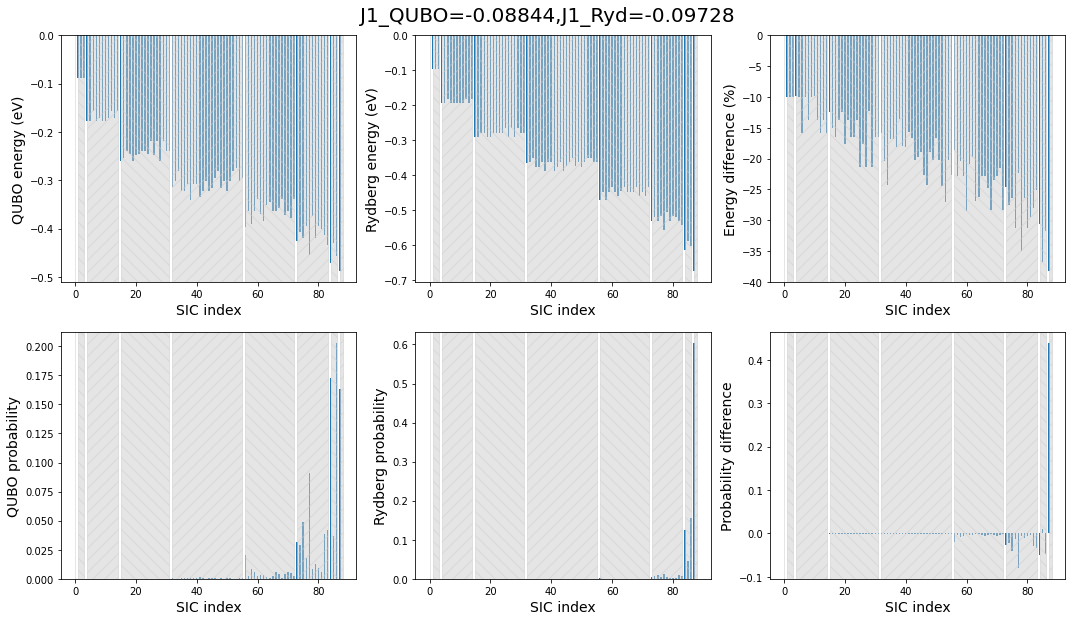

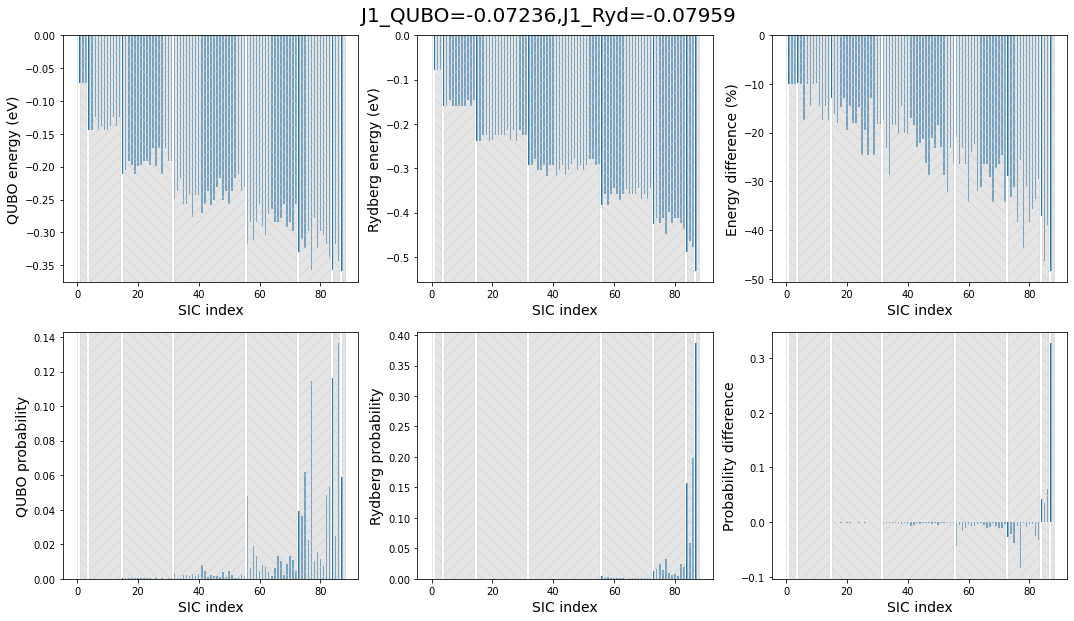

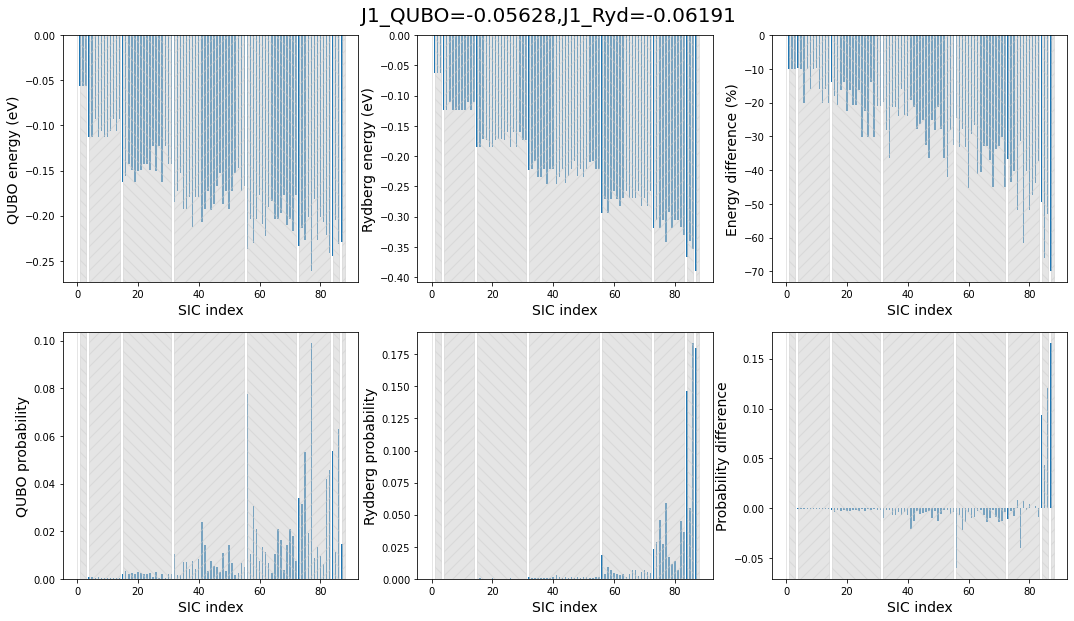

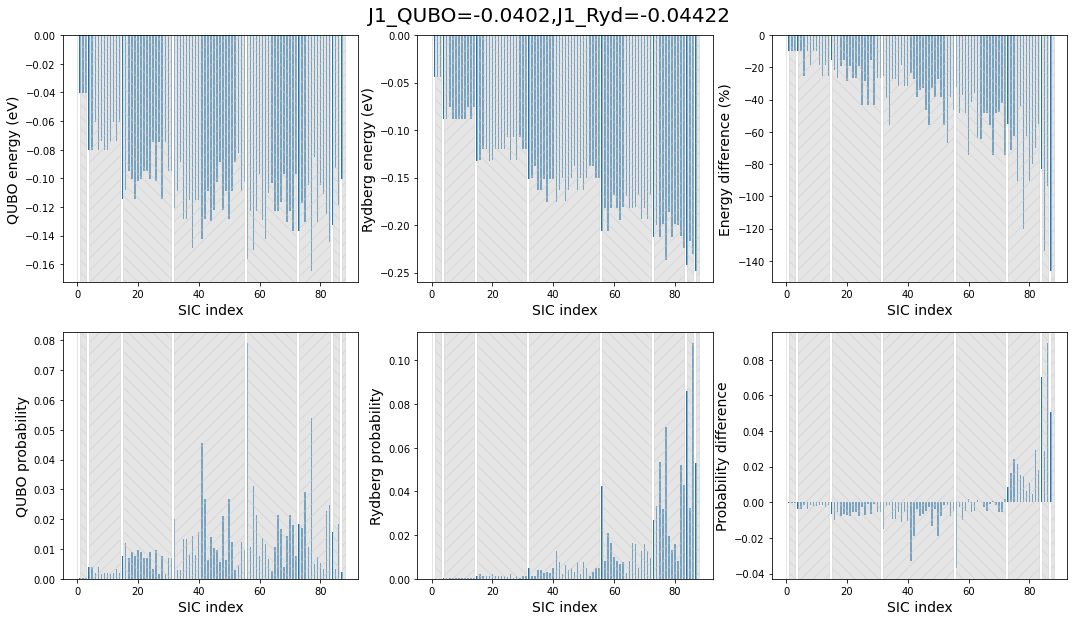

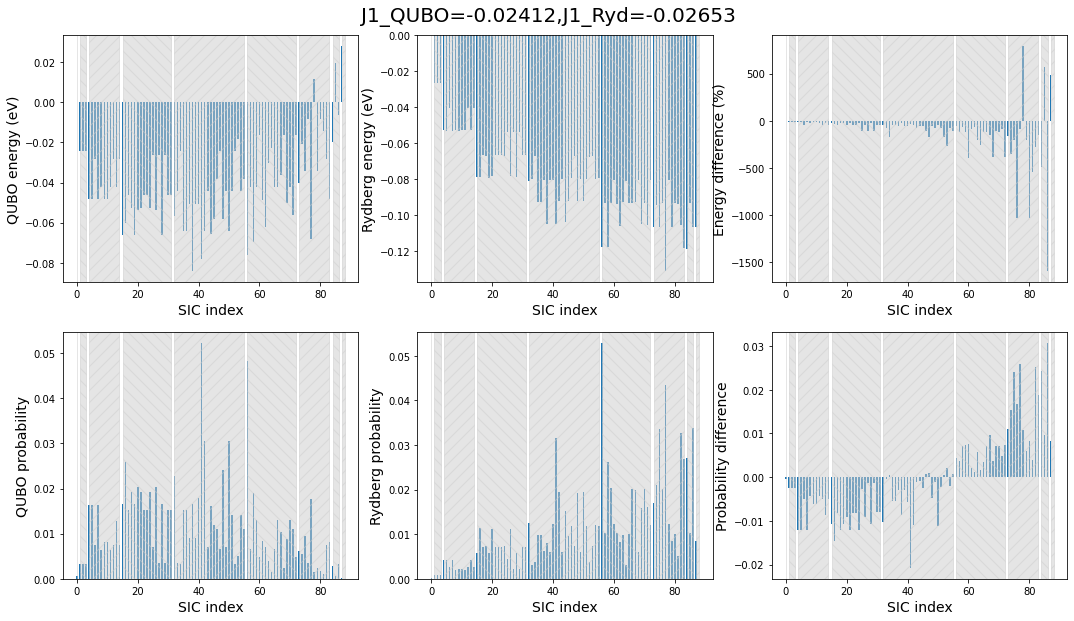

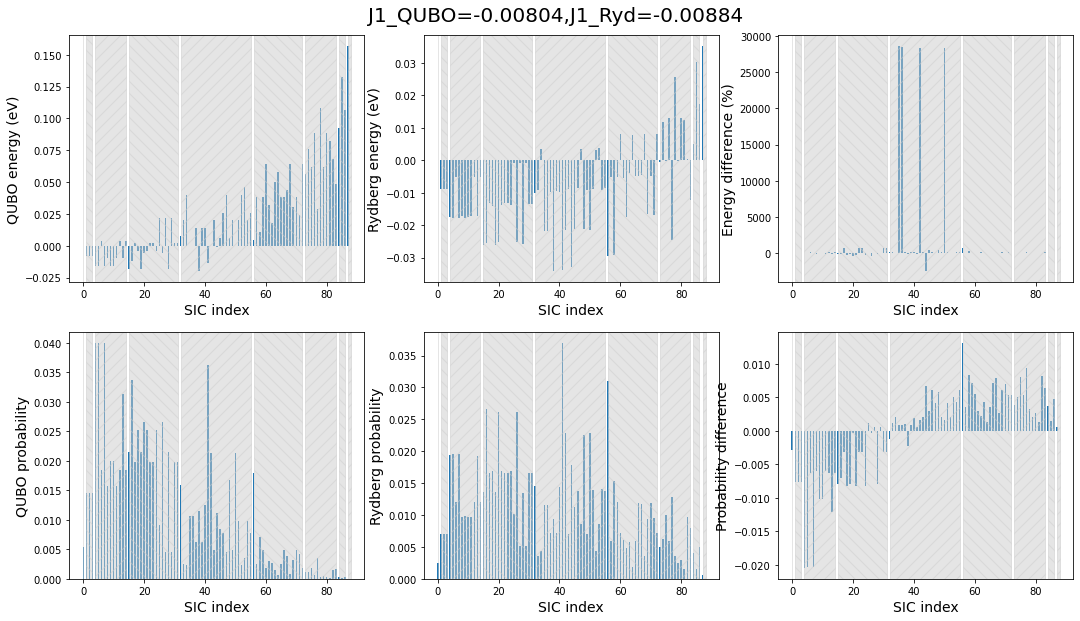

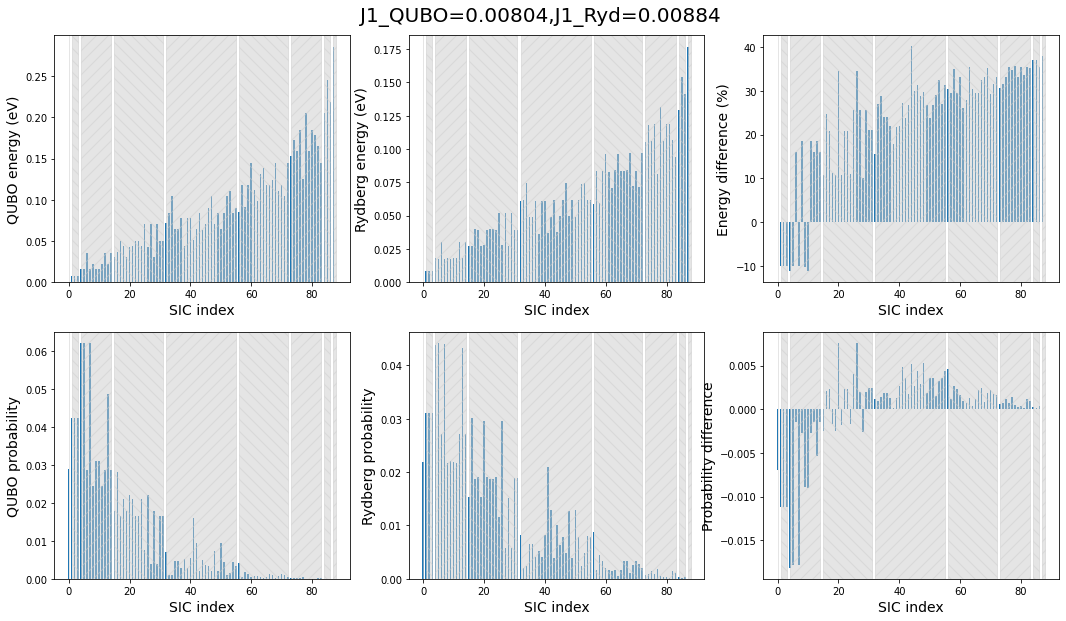

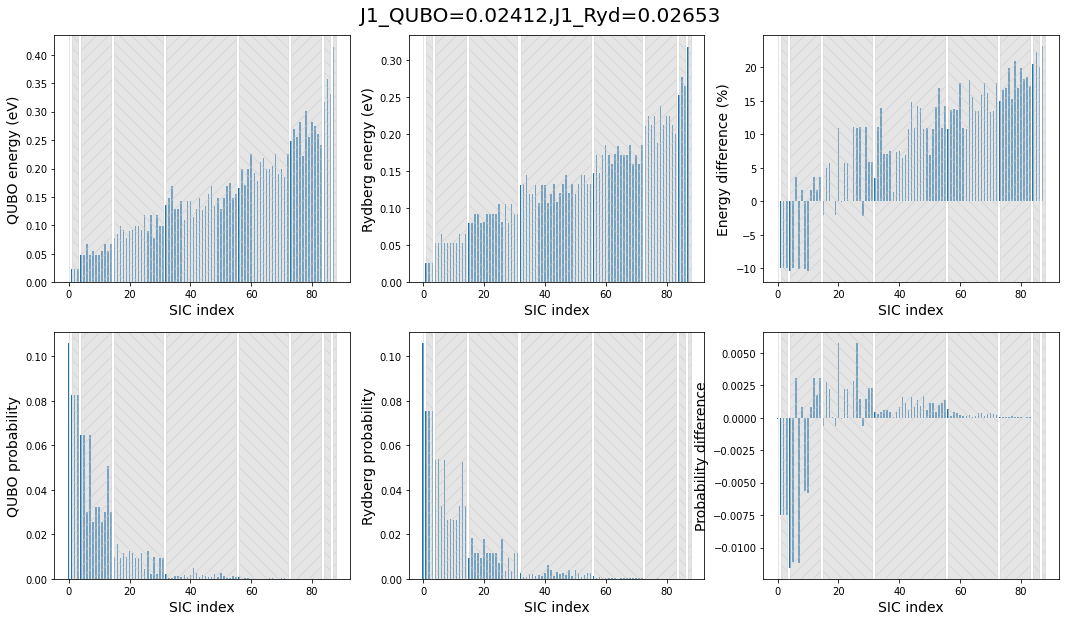

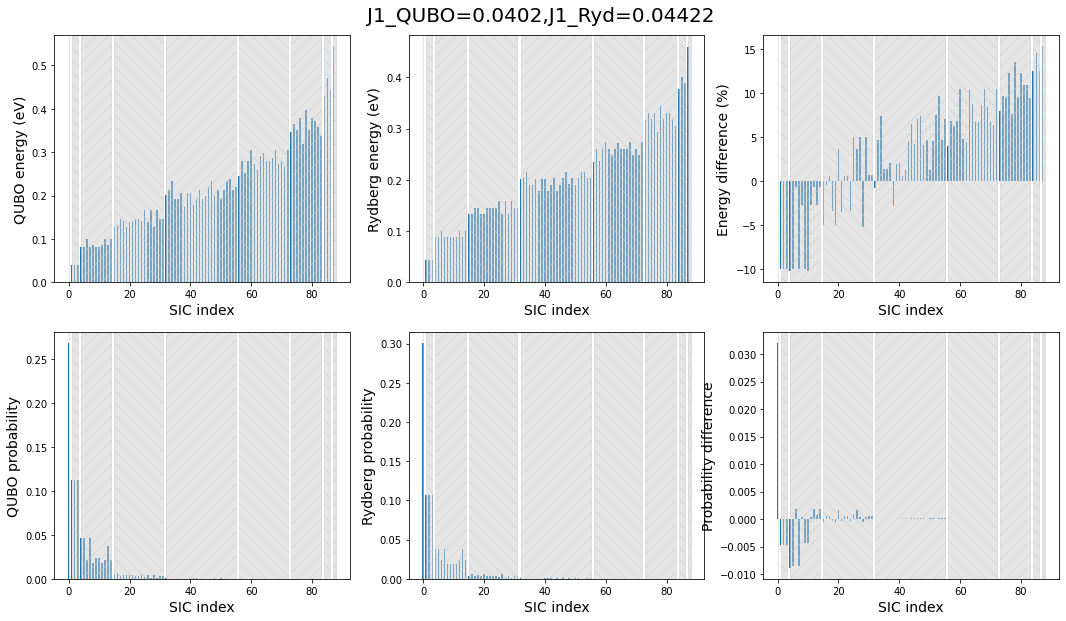

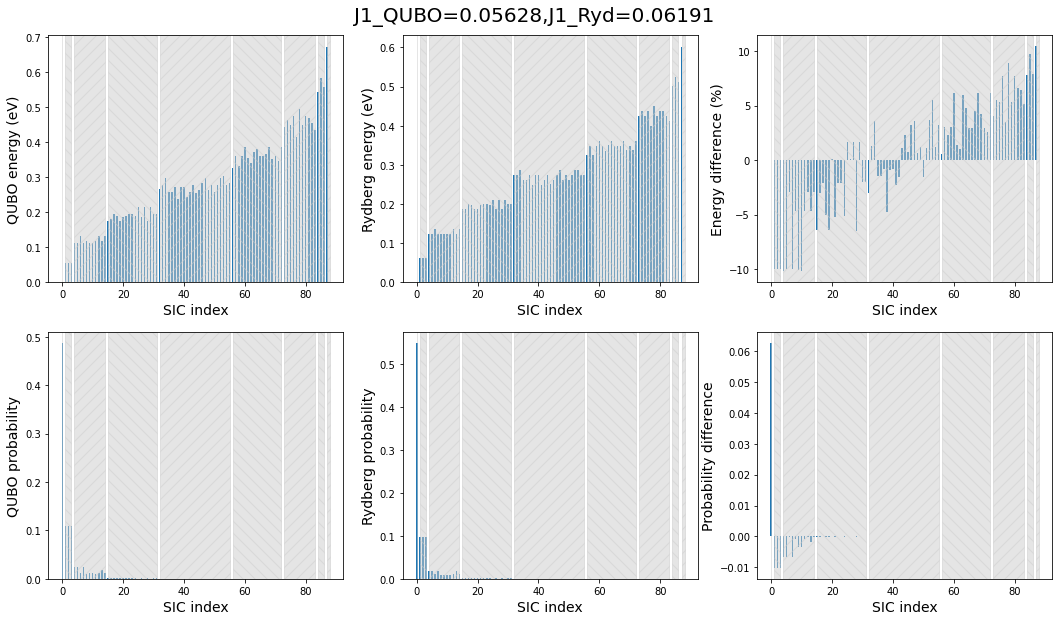

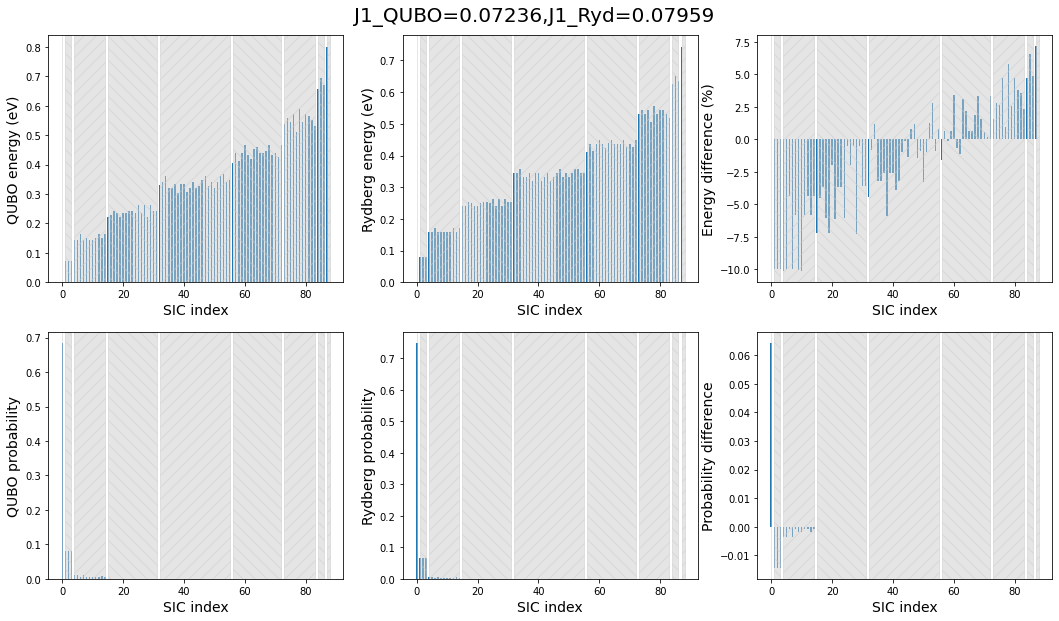

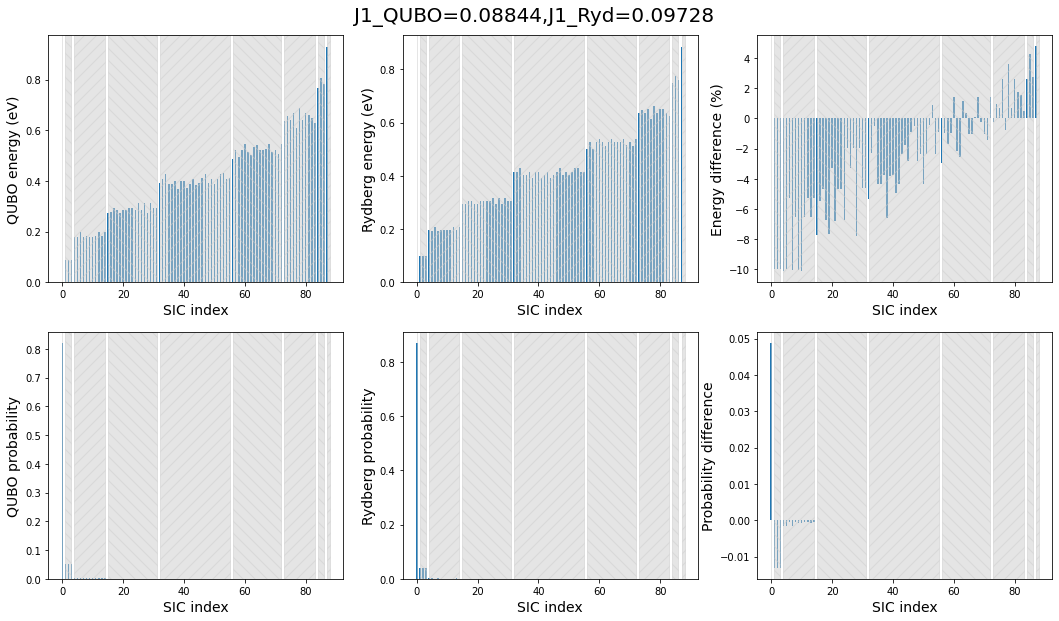

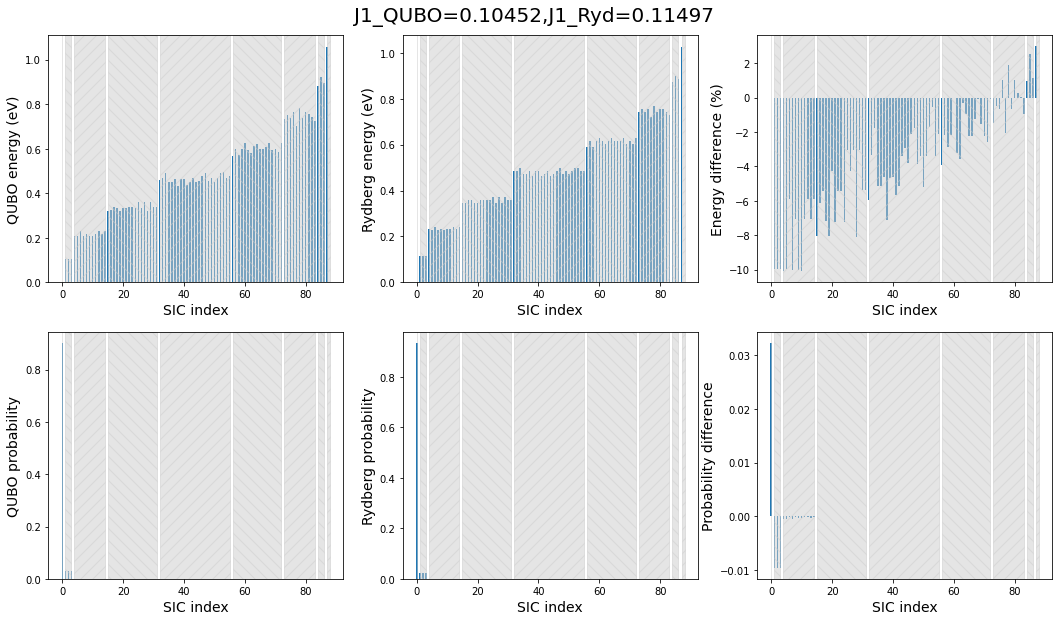

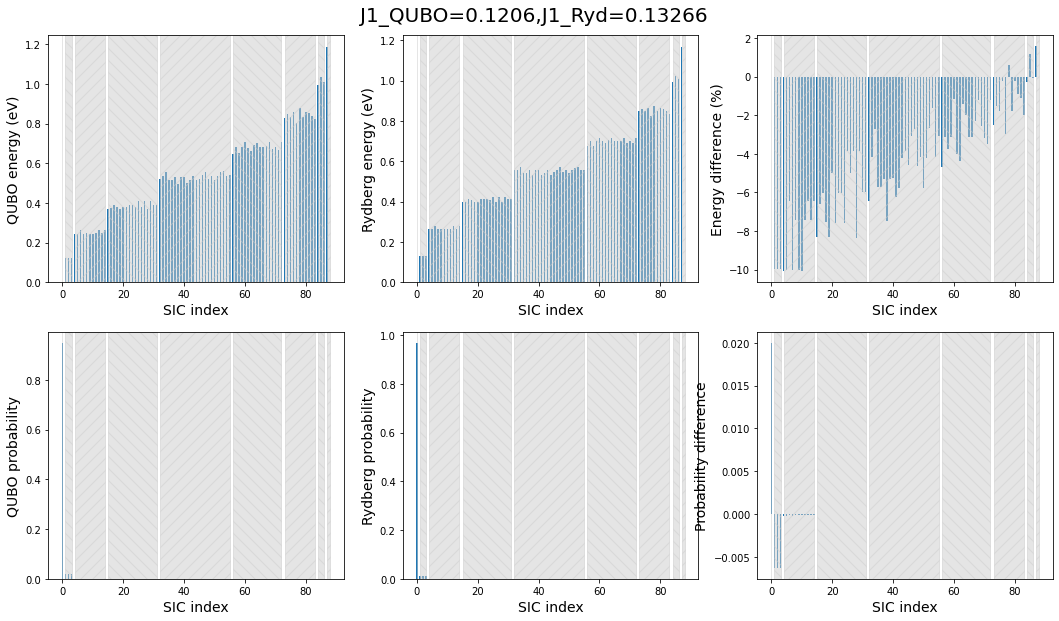

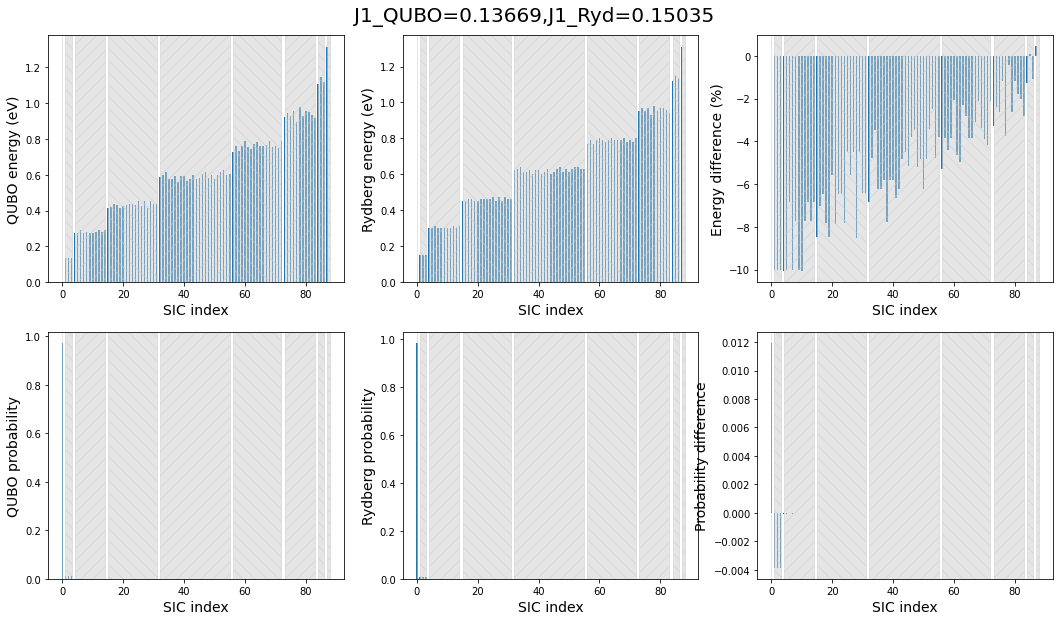

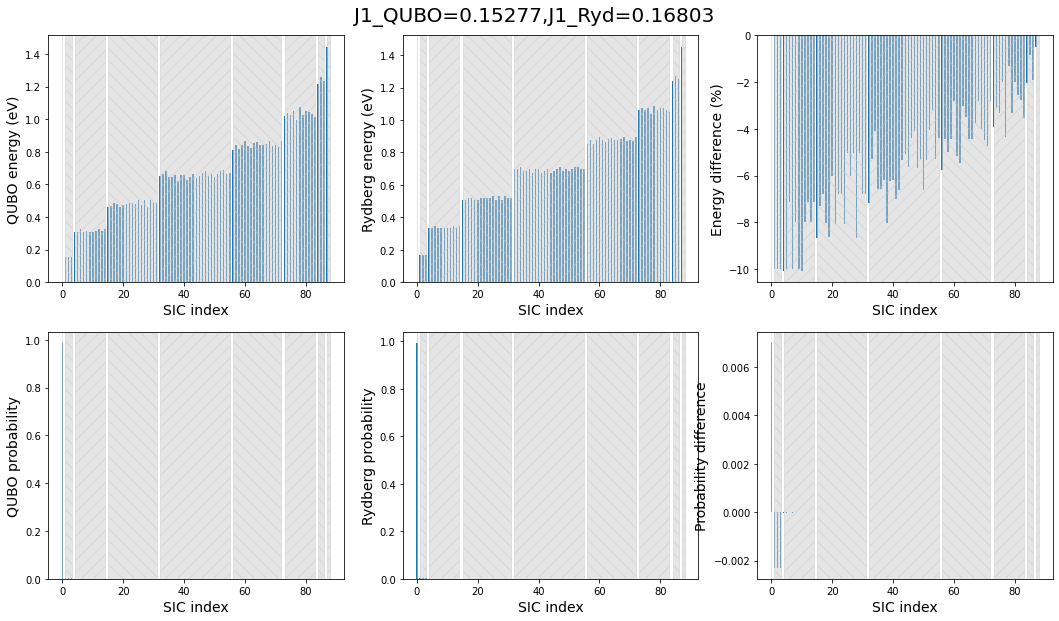

In [94]:
# optimised QUBO values
for mu in np.arange(-2.1,1,0.2):
    J1_ryd = 0.08843826 + 0.08843826*mu
    E_ryd = get_final_ryd_Hamiltonian_v2(
        coords, 
        detuning = 125000000.0,
        J1=J1_ryd,
        J2=0.01255761,
        C6 = 5.42e-24)[0]
    J1_QUBO = 0.080403+0.080403*mu
    E_QUBO = QUBO(neighbors, J1=J1_QUBO, J2=0.019894, J3=0.006172)[0]
    
    configurations = np.array(list(itertools.product([0, 1], repeat=8)))
    config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
    config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
    E_QUBO_sic = np.array(E_QUBO_sic)
    E_ryd_sic = np.array(E_ryd_sic)
    plot_E_p_differences_v2(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,
                            percent=True, title='J1_QUBO={},J1_Ryd={}'.format(
                                np.round(J1_QUBO,5),np.round(J1_ryd,5)))

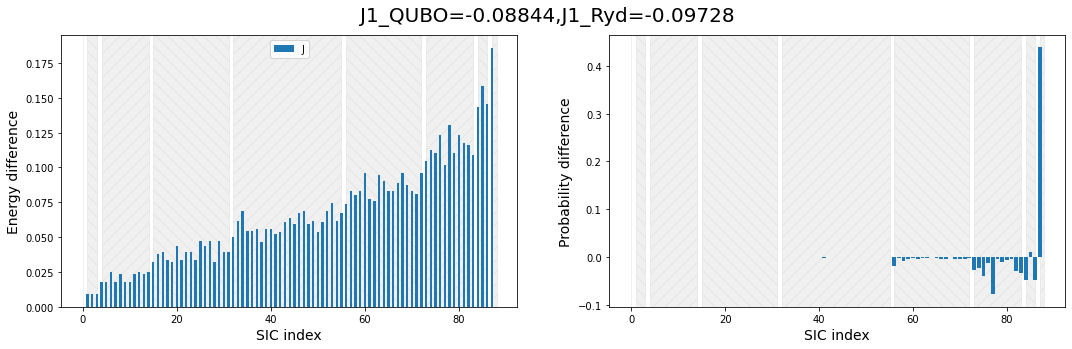

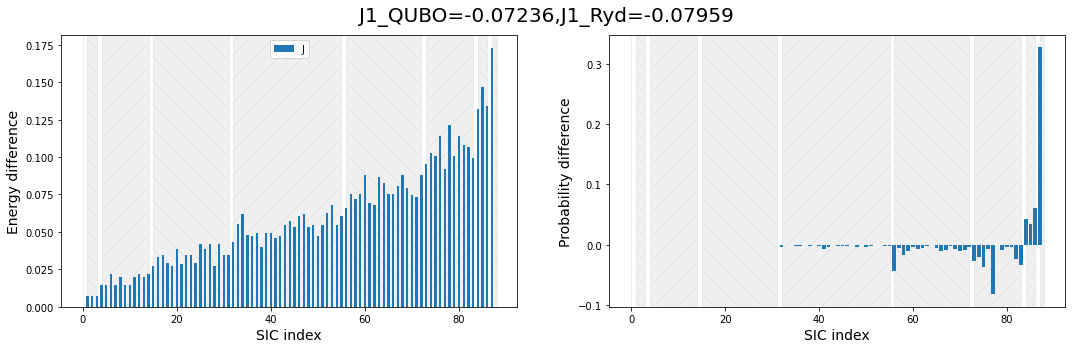

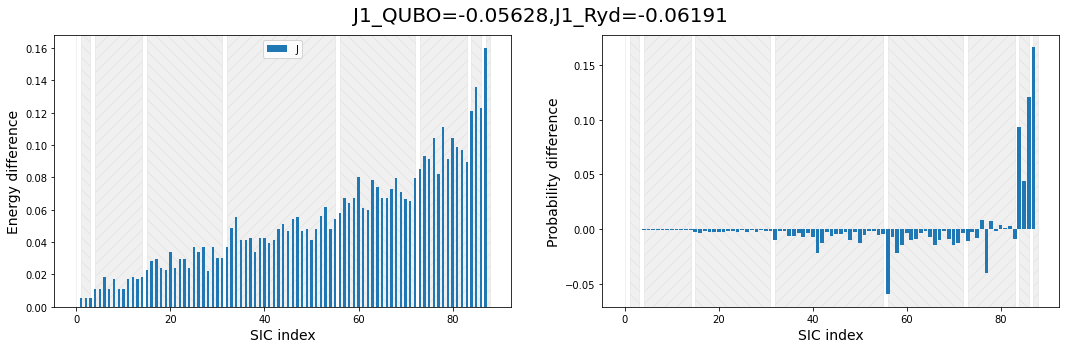

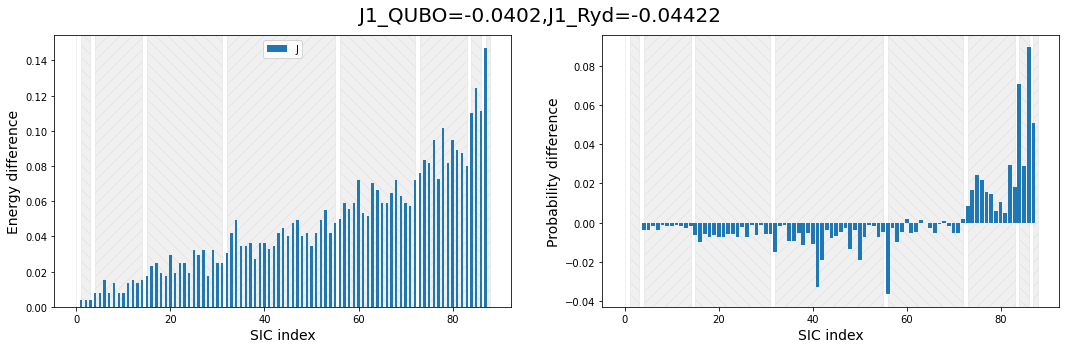

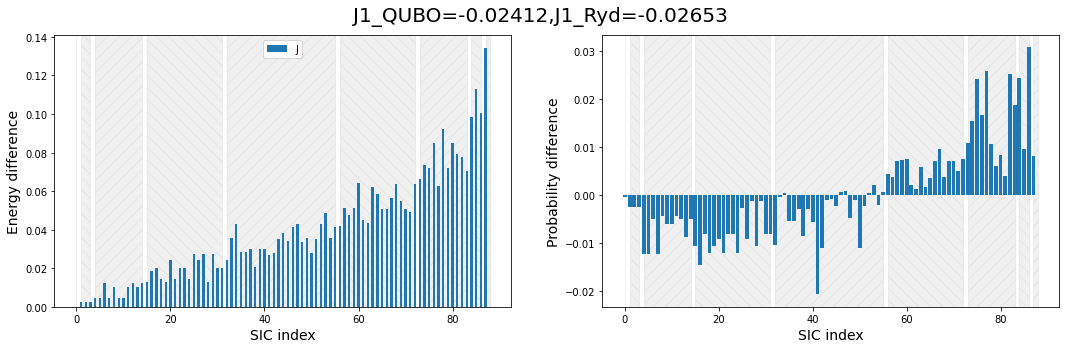

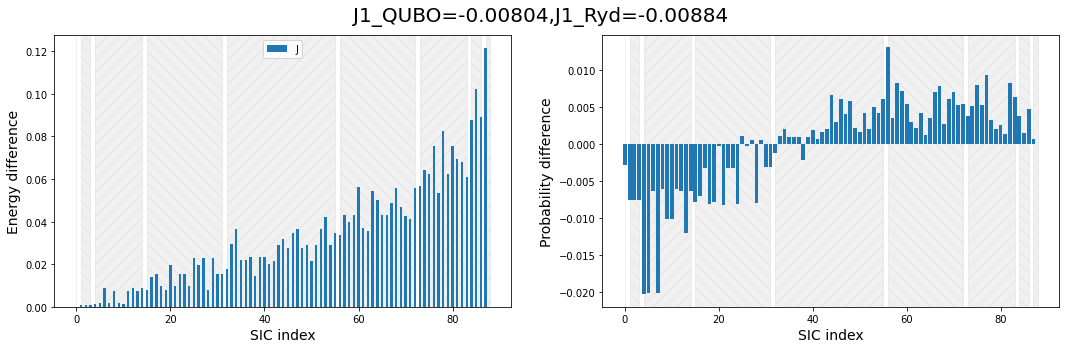

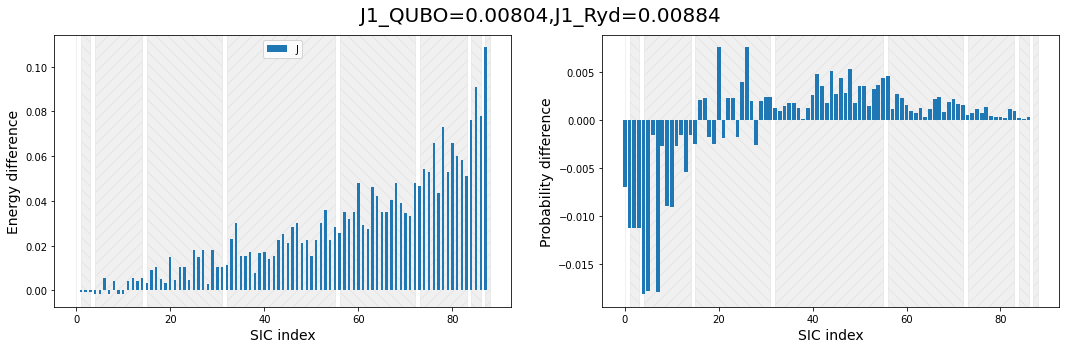

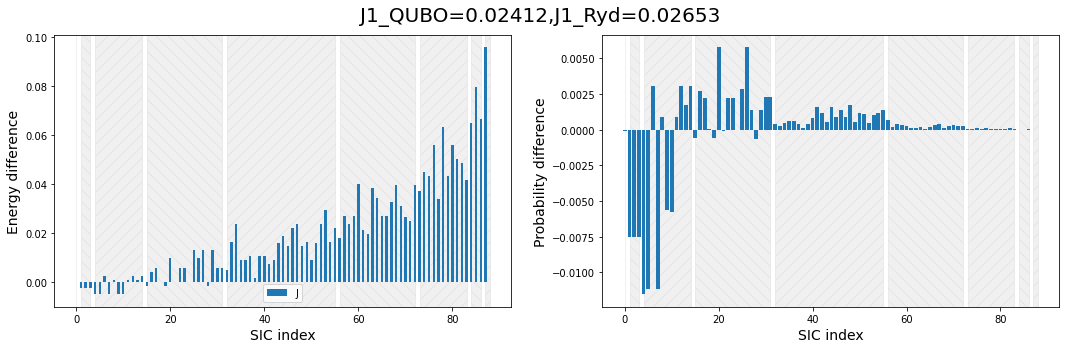

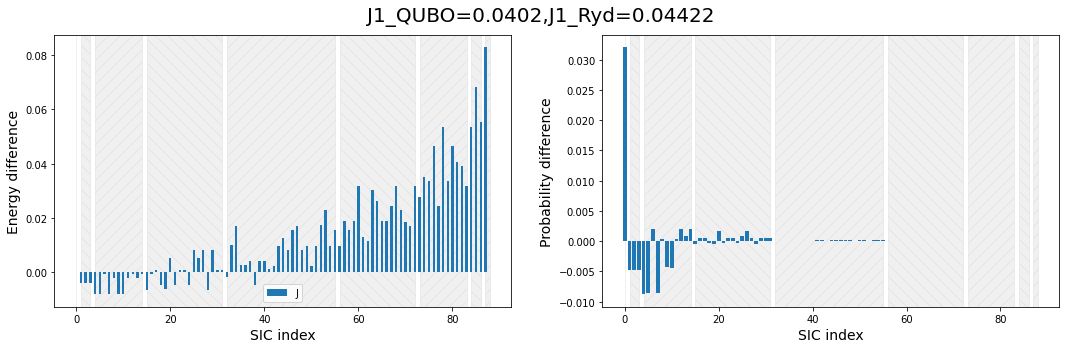

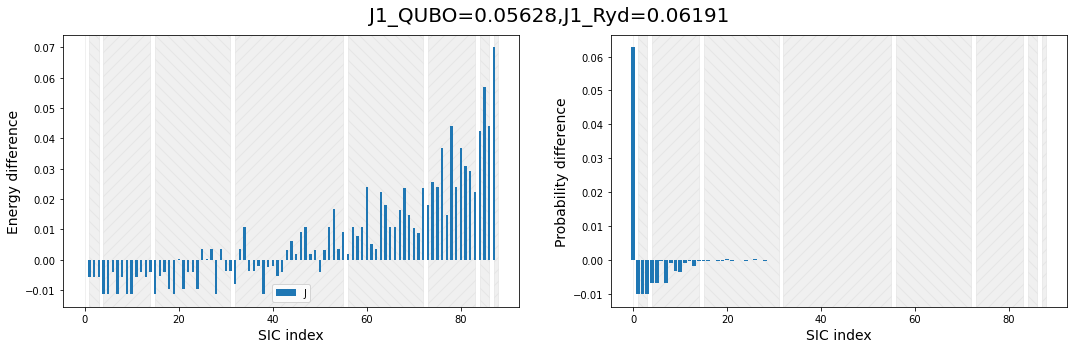

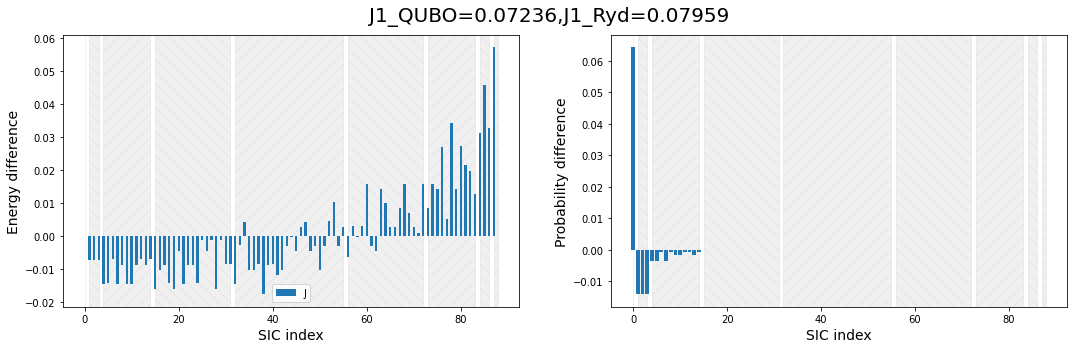

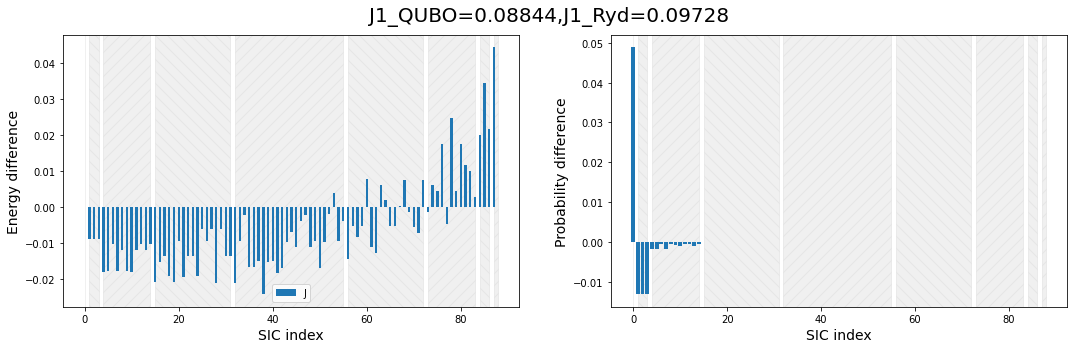

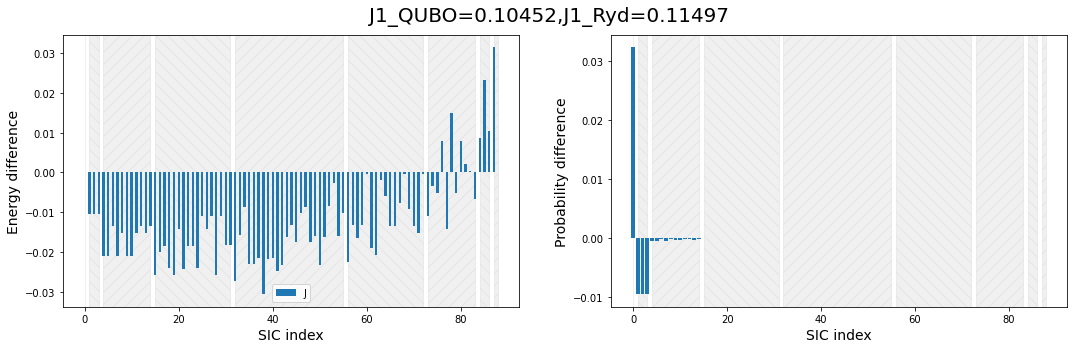

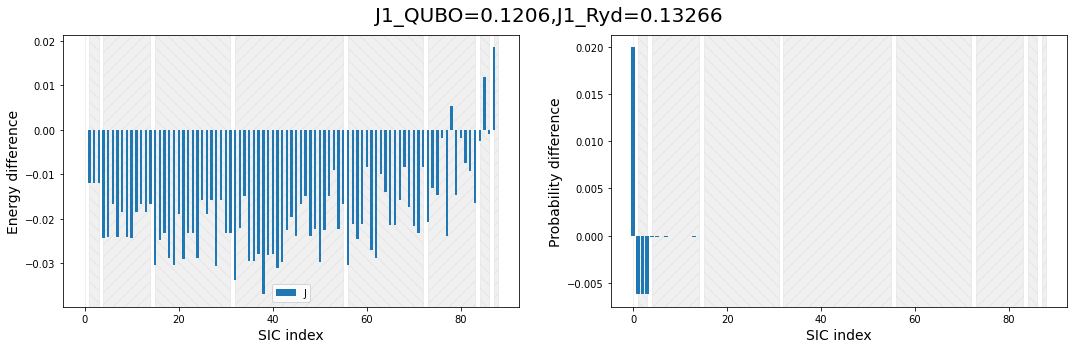

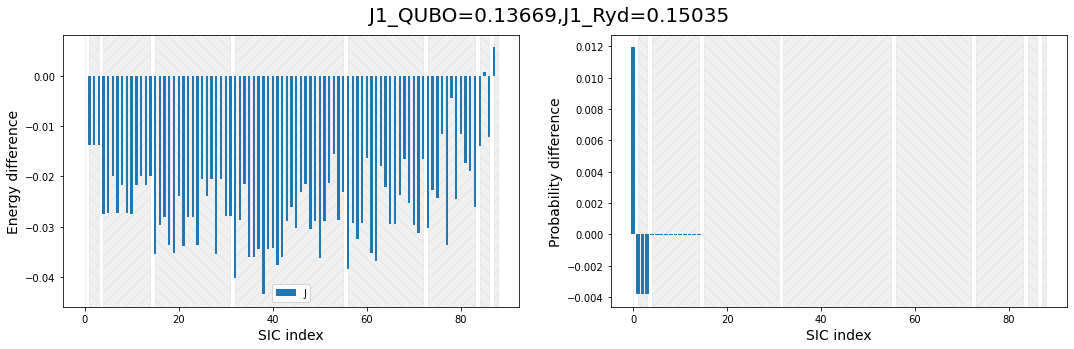

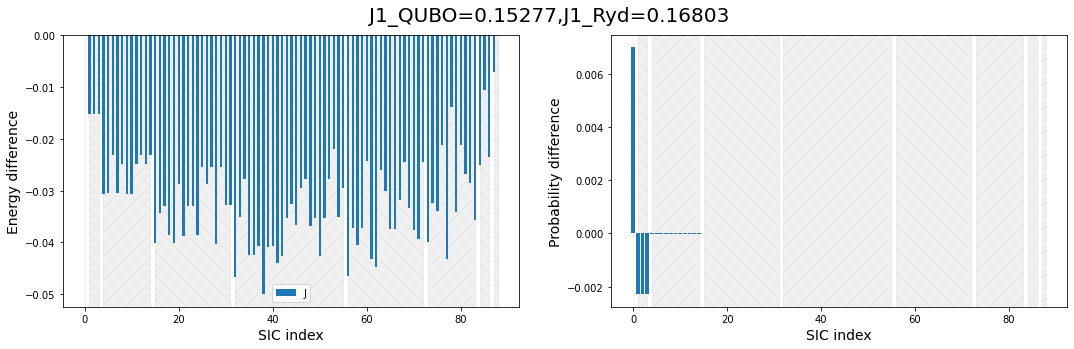

In [98]:
# optimised QUBO values
for mu in np.arange(-2.1,1,0.2):
    J1_ryd = 0.08843826 + 0.08843826*mu
    E_ryd = get_final_ryd_Hamiltonian_v2(
        coords, 
        detuning = 125000000.0,
        J1=J1_ryd,
        J2=0.01255761,
        C6 = 5.42e-24)[0]
    J1_QUBO = 0.080403+0.080403*mu
    E_QUBO = QUBO(neighbors, J1=J1_QUBO, J2=0.019894, J3=0.006172)[0]
    
    configurations = np.array(list(itertools.product([0, 1], repeat=8)))
    config_unique, E_QUBO_sic, multiplicity = find_sic(configurations,atom_indices,energies=E_QUBO,sort=True)
    config_unique, E_ryd_sic,multiplicity = find_sic(configurations,atom_indices,energies=E_ryd,sort=True)
    E_QUBO_sic = np.array(E_QUBO_sic)
    E_ryd_sic = np.array(E_ryd_sic)
    plot_E_p_differences(config_unique,multiplicity,E_QUBO_sic,E_ryd_sic,
                            percent=False, title='J1_QUBO={},J1_Ryd={}'.format(
                                np.round(J1_QUBO,5),np.round(J1_ryd,5)))